## ANN Model for loan prediction

You can download the database from
https://drive.google.com/file/d/1kEc4eXsmvZW-8gmL3q7l6T_bGKjUAM85/view?usp=sharing
It's almost more then 150 mb dataset

Used Keras and Keras Tuner (for selecting hidden layers and neural networks)

In [1]:
import pandas as pd
import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
loan_df = pd.read_csv('loan_data.csv')

In [3]:
loan_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Dtype  
---   ------                        -----  
 0    SK_ID_CURR                    int64  
 1    TARGET                        int64  
 2    NAME_CONTRACT_TYPE            object 
 3    CODE_GENDER                   object 
 4    FLAG_OWN_CAR                  object 
 5    FLAG_OWN_REALTY               object 
 6    CNT_CHILDREN                  int64  
 7    AMT_INCOME_TOTAL              float64
 8    AMT_CREDIT                    float64
 9    AMT_ANNUITY                   float64
 10   AMT_GOODS_PRICE               float64
 11   NAME_TYPE_SUITE               object 
 12   NAME_INCOME_TYPE              object 
 13   NAME_EDUCATION_TYPE           object 
 14   NAME_FAMILY_STATUS            object 
 15   NAME_HOUSING_TYPE             object 
 16   REGION_POPULATION_RELATIVE    float64
 17   DAYS_BIRTH                    int64  
 18   DA

## Data Preprocessing

In [4]:
loan_df.shape

(307511, 122)

In [5]:
# Removing irrelivent feature
loan_df.drop('SK_ID_CURR', axis=1, inplace=True)

Dividing dataset into numerical and categorical features

In [6]:
num_col = loan_df.select_dtypes(exclude = ['object']).columns
cat_col = loan_df.select_dtypes(include = ['object']).columns

In [7]:
num_col

Index(['TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=105)

In [8]:
cat_col

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')

### Handling missing values of categorical features

In [9]:
loan_df[cat_col].head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,reg oper account,block of flats,"Stone, brick",No
1,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,MONDAY,School,reg oper account,block of flats,Block,No
2,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,MONDAY,Government,NaN,NaN,NaN,NaN
3,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,NaN,NaN,NaN,NaN
4,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Core staff,THURSDAY,Religion,NaN,NaN,NaN,NaN


In [10]:
# checking for null values
loan_df[cat_col].isnull().sum()

NAME_CONTRACT_TYPE                 0
CODE_GENDER                        0
FLAG_OWN_CAR                       0
FLAG_OWN_REALTY                    0
NAME_TYPE_SUITE                 1292
NAME_INCOME_TYPE                   0
NAME_EDUCATION_TYPE                0
NAME_FAMILY_STATUS                 0
NAME_HOUSING_TYPE                  0
OCCUPATION_TYPE                96391
WEEKDAY_APPR_PROCESS_START         0
ORGANIZATION_TYPE                  0
FONDKAPREMONT_MODE            210295
HOUSETYPE_MODE                154297
WALLSMATERIAL_MODE            156341
EMERGENCYSTATE_MODE           145755
dtype: int64

In [11]:
null_cat_col = loan_df[cat_col].loc[:,(loan_df[cat_col].isnull().sum()>0)].columns
null_cat_col

Index(['NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')

In [12]:
null_cat_col = loan_df[cat_col].loc[:,loan_df[cat_col].isnull().sum()>0].columns
null_cat_col

Index(['NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')

In [13]:
loan_df[null_cat_col].isnull().sum()/loan_df.shape[0]

NAME_TYPE_SUITE        0.004201
OCCUPATION_TYPE        0.313455
FONDKAPREMONT_MODE     0.683862
HOUSETYPE_MODE         0.501761
WALLSMATERIAL_MODE     0.508408
EMERGENCYSTATE_MODE    0.473983
dtype: float64

### Impute categorical null values with Random Sample Imputer for missing data < 50%

In [14]:
rsi_cols = loan_df[null_cat_col].loc[:,loan_df[null_cat_col].isnull().sum()/loan_df.shape[0]<0.50].columns
rsi_cols

Index(['NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'EMERGENCYSTATE_MODE'], dtype='object')

In [15]:
for col in rsi_cols:
    samples = loan_df[col].dropna().sample(loan_df[col].isnull().sum())
    samples.index = loan_df[col][loan_df[col].isnull()].index
    loan_df[col][loan_df[col].isnull()] = samples

<ipython-input-15-83ad885c16fa>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_df[col][loan_df[col].isnull()] = samples


In [16]:
null_cat_col = loan_df[cat_col].loc[:,loan_df[cat_col].isnull().sum()>0].columns
null_cat_col

Index(['FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE'], dtype='object')

### Impute categorical null values with mode for missing values > 50%

In [17]:
for col in null_cat_col:
    loan_df[col].fillna(loan_df[col].mode()[0], inplace=True)

In [18]:
loan_df[cat_col].isnull().sum()

NAME_CONTRACT_TYPE            0
CODE_GENDER                   0
FLAG_OWN_CAR                  0
FLAG_OWN_REALTY               0
NAME_TYPE_SUITE               0
NAME_INCOME_TYPE              0
NAME_EDUCATION_TYPE           0
NAME_FAMILY_STATUS            0
NAME_HOUSING_TYPE             0
OCCUPATION_TYPE               0
WEEKDAY_APPR_PROCESS_START    0
ORGANIZATION_TYPE             0
FONDKAPREMONT_MODE            0
HOUSETYPE_MODE                0
WALLSMATERIAL_MODE            0
EMERGENCYSTATE_MODE           0
dtype: int64

## Handling missing values of Numerical Features

In [19]:
null_num_col = loan_df[num_col].loc[:,(loan_df[num_col].isnull().sum()>0)].columns
null_num_col

Index(['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS',
       'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG',
       'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG',
       'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG',
       'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG',
       'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG',
       'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE',
       'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE',
       'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE',
       'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE',
       'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI',
       'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI',
       'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI',
       'LANDAREA_MEDI', 'LIVINGAPART

In [20]:
loan_df[null_num_col].isnull().sum()

AMT_ANNUITY                       12
AMT_GOODS_PRICE                  278
OWN_CAR_AGE                   202929
CNT_FAM_MEMBERS                    2
EXT_SOURCE_1                  173378
                               ...  
AMT_REQ_CREDIT_BUREAU_DAY      41519
AMT_REQ_CREDIT_BUREAU_WEEK     41519
AMT_REQ_CREDIT_BUREAU_MON      41519
AMT_REQ_CREDIT_BUREAU_QRT      41519
AMT_REQ_CREDIT_BUREAU_YEAR     41519
Length: 61, dtype: int64

In [21]:
# missing data in percentage
loan_df[null_num_col].isnull().sum()

AMT_ANNUITY                       12
AMT_GOODS_PRICE                  278
OWN_CAR_AGE                   202929
CNT_FAM_MEMBERS                    2
EXT_SOURCE_1                  173378
                               ...  
AMT_REQ_CREDIT_BUREAU_DAY      41519
AMT_REQ_CREDIT_BUREAU_WEEK     41519
AMT_REQ_CREDIT_BUREAU_MON      41519
AMT_REQ_CREDIT_BUREAU_QRT      41519
AMT_REQ_CREDIT_BUREAU_YEAR     41519
Length: 61, dtype: int64

In [22]:
len(null_num_col)

61

### Spliting into < 50% and >=50% missing data

In [23]:
less_50 = loan_df[null_num_col].loc[:,loan_df[null_num_col].isnull().sum()/loan_df[null_num_col].shape[0] < 0.50].columns
less_50

Index(['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'YEARS_BEGINEXPLUATATION_AVG', 'FLOORSMAX_AVG',
       'YEARS_BEGINEXPLUATATION_MODE', 'FLOORSMAX_MODE',
       'YEARS_BEGINEXPLUATATION_MEDI', 'FLOORSMAX_MEDI', 'TOTALAREA_MODE',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object')

In [24]:
gr_eq_50 = loan_df[null_num_col].loc[:,loan_df[null_num_col].isnull().sum()/loan_df.shape[0]>=0.50].columns
gr_eq_50

Index(['OWN_CAR_AGE', 'EXT_SOURCE_1', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG',
       'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG',
       'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG',
       'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG',
       'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BUILD_MODE',
       'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMIN_MODE',
       'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI',
       'BASEMENTAREA_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI',
       'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI',
       'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI',
       'NONLIVINGAREA_MEDI'],
      dtype='object')

In [25]:
# Analysing < 50% missing data values

In [26]:
loan_df[less_50].describe().T

,count,mean,std,min,25%,50%,75%,max
AMT_ANNUITY,307499.0,27108.573909,14493.737315,1.615500e+03,16524.000000,24903.000000,34596.000000,2.580255e+05
AMT_GOODS_PRICE,307233.0,538396.207429,369446.460540,4.050000e+04,238500.000000,450000.000000,679500.000000,4.050000e+06
CNT_FAM_MEMBERS,307509.0,2.152665,0.910682,1.000000e+00,2.000000,2.000000,3.000000,2.000000e+01
EXT_SOURCE_2,306851.0,0.514393,0.191060,8.173617e-08,0.392457,0.565961,0.663617,8.549997e-01
EXT_SOURCE_3,246546.0,0.510853,0.194844,5.272652e-04,0.370650,0.535276,0.669057,8.960095e-01
YEARS_BEGINEXPLUATATION_AVG,157504.0,0.977735,0.059223,0.000000e+00,0.976700,0.981600,0.986600,1.000000e+00
FLOORSMAX_AVG,154491.0,0.226282,0.144641,0.000000e+00,0.166700,0.166700,0.333300,1.000000e+00
YEARS_BEGINEXPLUATATION_MODE,157504.0,0.977065,0.064575,0.000000e+00,0.976700,0.981600,0.986600,1.000000e+00
FLOORSMAX_MODE,154491.0,0.222315,0.143709,0.000000e+00,0.166700,0.166700,0.333300,1.000000e+00
YEARS_BEGINEXPLUATATION_MEDI,157504.0,0.977752,0.059897,0.000000e+00,0.976700,0.981600,0.986600,1.000000e+00


## Imputing random values if data missing less then 50%

In [27]:
def plotKdeChart(col):
    sns.kdeplot(x=loan_df[col], c='r')
    sns.kdeplot(x=loan_df[col+'_impute'], c='g')
    plt.title('Data distribution Comparison of '+col)
    plt.show()

In [28]:
def imputeRandomVal(col):
    rand_val = loan_df[col].dropna().sample(loan_df[col].isnull().sum())
    loan_df[col+'_impute'] = loan_df[col]
    rand_val.index = loan_df[loan_df[col].isnull()].index
    loan_df[col+'_impute'][loan_df[col].isnull()] = rand_val
    plotKdeChart(col)

<ipython-input-28-435dd7a3c348>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_df[col+'_impute'][loan_df[col].isnull()] = rand_val


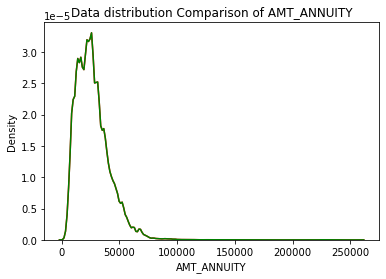

<ipython-input-28-435dd7a3c348>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_df[col+'_impute'][loan_df[col].isnull()] = rand_val


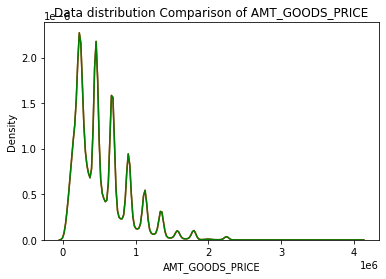

<ipython-input-28-435dd7a3c348>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_df[col+'_impute'][loan_df[col].isnull()] = rand_val


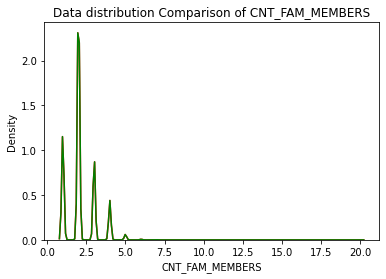

<ipython-input-28-435dd7a3c348>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_df[col+'_impute'][loan_df[col].isnull()] = rand_val


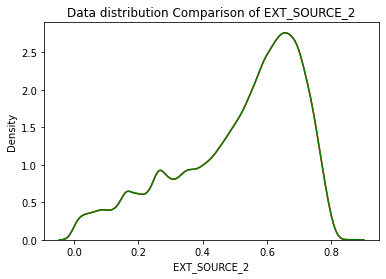

<ipython-input-28-435dd7a3c348>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_df[col+'_impute'][loan_df[col].isnull()] = rand_val


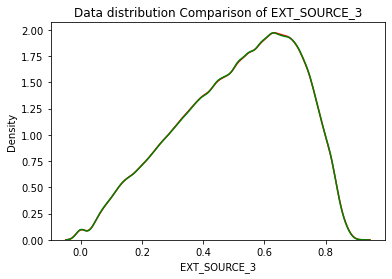

<ipython-input-28-435dd7a3c348>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_df[col+'_impute'][loan_df[col].isnull()] = rand_val


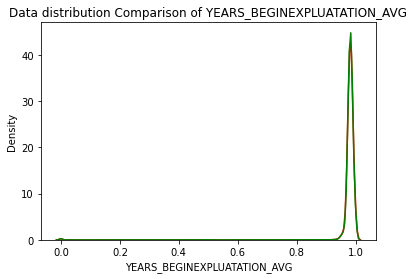

<ipython-input-28-435dd7a3c348>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_df[col+'_impute'][loan_df[col].isnull()] = rand_val


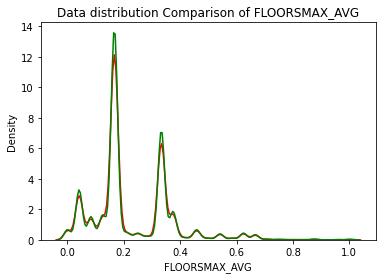

<ipython-input-28-435dd7a3c348>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_df[col+'_impute'][loan_df[col].isnull()] = rand_val


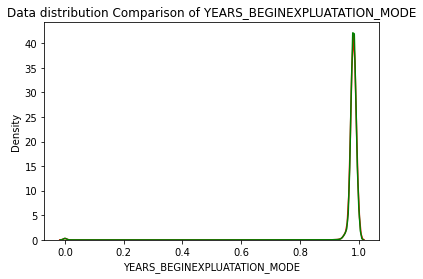

<ipython-input-28-435dd7a3c348>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_df[col+'_impute'][loan_df[col].isnull()] = rand_val


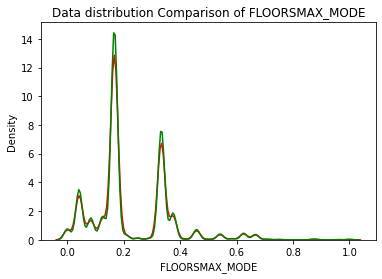

<ipython-input-28-435dd7a3c348>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_df[col+'_impute'][loan_df[col].isnull()] = rand_val


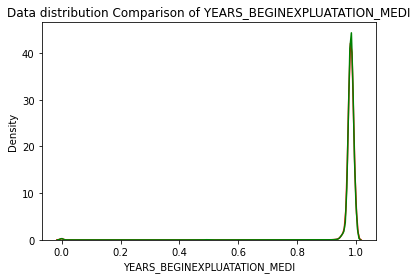

<ipython-input-28-435dd7a3c348>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_df[col+'_impute'][loan_df[col].isnull()] = rand_val


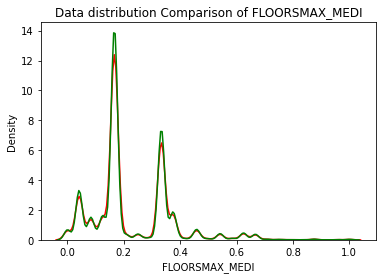

<ipython-input-28-435dd7a3c348>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_df[col+'_impute'][loan_df[col].isnull()] = rand_val


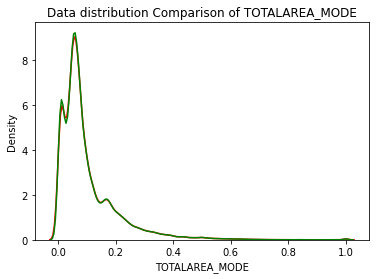

<ipython-input-28-435dd7a3c348>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_df[col+'_impute'][loan_df[col].isnull()] = rand_val


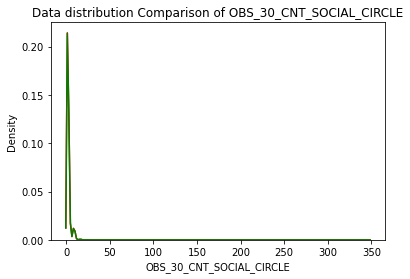

<ipython-input-28-435dd7a3c348>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_df[col+'_impute'][loan_df[col].isnull()] = rand_val


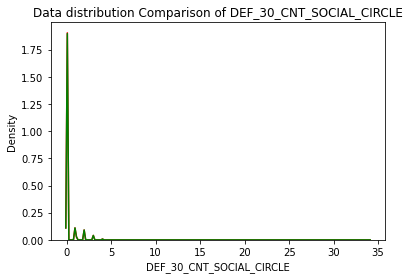

<ipython-input-28-435dd7a3c348>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_df[col+'_impute'][loan_df[col].isnull()] = rand_val


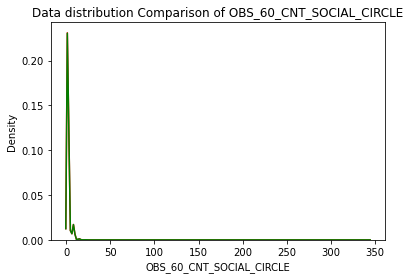

<ipython-input-28-435dd7a3c348>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_df[col+'_impute'][loan_df[col].isnull()] = rand_val


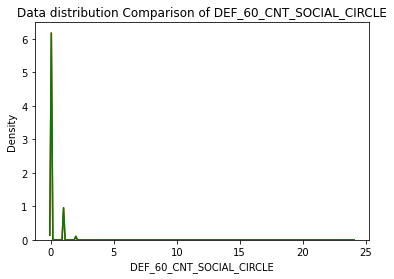

<ipython-input-28-435dd7a3c348>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_df[col+'_impute'][loan_df[col].isnull()] = rand_val


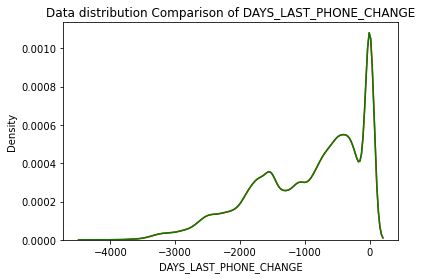

<ipython-input-28-435dd7a3c348>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_df[col+'_impute'][loan_df[col].isnull()] = rand_val


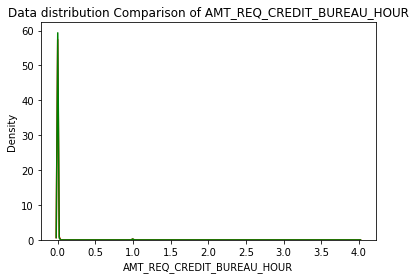

<ipython-input-28-435dd7a3c348>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_df[col+'_impute'][loan_df[col].isnull()] = rand_val


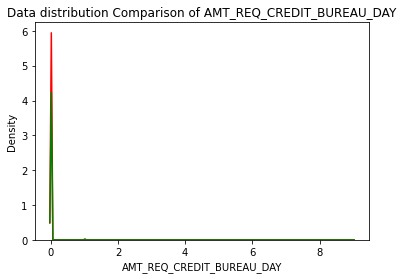

<ipython-input-28-435dd7a3c348>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_df[col+'_impute'][loan_df[col].isnull()] = rand_val


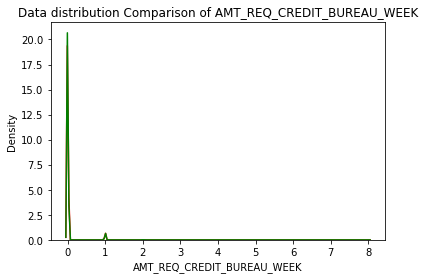

<ipython-input-28-435dd7a3c348>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_df[col+'_impute'][loan_df[col].isnull()] = rand_val


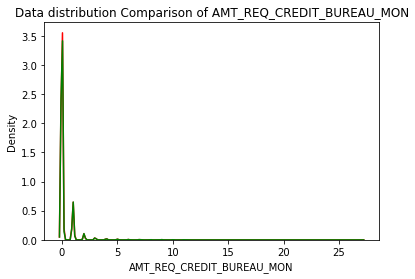

<ipython-input-28-435dd7a3c348>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_df[col+'_impute'][loan_df[col].isnull()] = rand_val


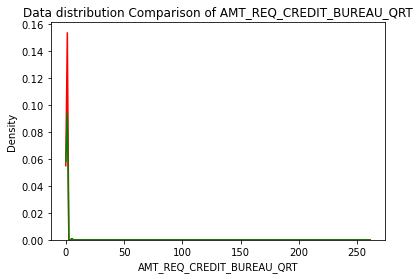

<ipython-input-28-435dd7a3c348>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_df[col+'_impute'][loan_df[col].isnull()] = rand_val


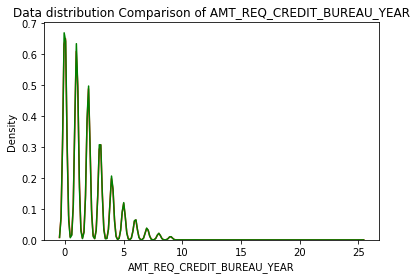

In [29]:
for col in less_50:
    imputeRandomVal(col)

We can clearly see on above plots that data variance is almost same after imputing random missing values. Now we can drop less_50 columns and keep imputed cols

In [30]:
loan_df.drop(less_50, axis=1, inplace=True)
loan_df.columns

Index(['TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       ...
       'DEF_30_CNT_SOCIAL_CIRCLE_impute', 'OBS_60_CNT_SOCIAL_CIRCLE_impute',
       'DEF_60_CNT_SOCIAL_CIRCLE_impute', 'DAYS_LAST_PHONE_CHANGE_impute',
       'AMT_REQ_CREDIT_BUREAU_HOUR_impute', 'AMT_REQ_CREDIT_BUREAU_DAY_impute',
       'AMT_REQ_CREDIT_BUREAU_WEEK_impute', 'AMT_REQ_CREDIT_BUREAU_MON_impute',
       'AMT_REQ_CREDIT_BUREAU_QRT_impute',
       'AMT_REQ_CREDIT_BUREAU_YEAR_impute'],
      dtype='object', length=121)

In [31]:
loan_df[gr_eq_50].describe().T

,count,mean,std,min,25%,50%,75%,max
OWN_CAR_AGE,104582.0,12.061091,11.944812,0.000000,5.000000,9.000000,15.000000,91.000000
EXT_SOURCE_1,134133.0,0.502130,0.211062,0.014568,0.334007,0.505998,0.675053,0.962693
APARTMENTS_AVG,151450.0,0.117440,0.108240,0.000000,0.057700,0.087600,0.148500,1.000000
BASEMENTAREA_AVG,127568.0,0.088442,0.082438,0.000000,0.044200,0.076300,0.112200,1.000000
YEARS_BUILD_AVG,103023.0,0.752471,0.113280,0.000000,0.687200,0.755200,0.823200,1.000000
COMMONAREA_AVG,92646.0,0.044621,0.076036,0.000000,0.007800,0.021100,0.051500,1.000000
ELEVATORS_AVG,143620.0,0.078942,0.134576,0.000000,0.000000,0.000000,0.120000,1.000000
ENTRANCES_AVG,152683.0,0.149725,0.100049,0.000000,0.069000,0.137900,0.206900,1.000000
FLOORSMIN_AVG,98869.0,0.231894,0.161380,0.000000,0.083300,0.208300,0.375000,1.000000
LANDAREA_AVG,124921.0,0.066333,0.081184,0.000000,0.018700,0.048100,0.085600,1.000000


OWN_CAR_AGE feature has high mean its data is not normally distributed. There are chances that it contains the outliers

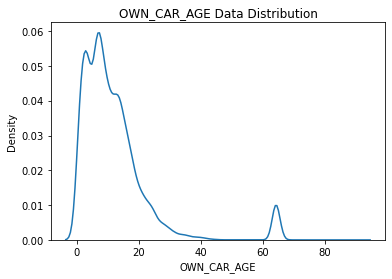

In [32]:
sns.kdeplot(x=loan_df['OWN_CAR_AGE'])
plt.title('OWN_CAR_AGE Data Distribution')
plt.show()

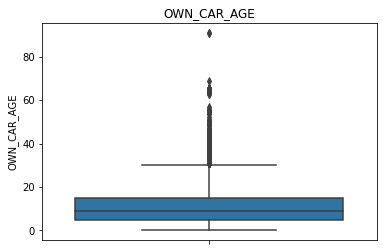

In [33]:
sns.boxplot(y=loan_df['OWN_CAR_AGE'])
plt.title('OWN_CAR_AGE')
plt.show()

As we suspected there are some outliers present so we can't do mean imputation in it for this we will do median imputation and for rest of the features we will go for mean imputation

In [34]:
for col in gr_eq_50:
    if(col != 'OWN_CAN_AGE'):
        loan_df[col].fillna(loan_df[col].mean(), inplace=True)
    else:
        loan_df[col].fillna(loan_df[col].medain(), inplace=True)
        
loan_df.isnull().sum()

TARGET                               0
NAME_CONTRACT_TYPE                   0
CODE_GENDER                          0
FLAG_OWN_CAR                         0
FLAG_OWN_REALTY                      0
                                    ..
AMT_REQ_CREDIT_BUREAU_DAY_impute     0
AMT_REQ_CREDIT_BUREAU_WEEK_impute    0
AMT_REQ_CREDIT_BUREAU_MON_impute     0
AMT_REQ_CREDIT_BUREAU_QRT_impute     0
AMT_REQ_CREDIT_BUREAU_YEAR_impute    0
Length: 121, dtype: int64

## ------------ Imputed all missing values ------------------

## Checking for numerical categorical feature in dataset

In [35]:
# updated numeric columns
num_cols = loan_df.drop('TARGET', axis=1).select_dtypes(exclude='object').columns
num_cols

Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL',
       ...
       'DEF_30_CNT_SOCIAL_CIRCLE_impute', 'OBS_60_CNT_SOCIAL_CIRCLE_impute',
       'DEF_60_CNT_SOCIAL_CIRCLE_impute', 'DAYS_LAST_PHONE_CHANGE_impute',
       'AMT_REQ_CREDIT_BUREAU_HOUR_impute', 'AMT_REQ_CREDIT_BUREAU_DAY_impute',
       'AMT_REQ_CREDIT_BUREAU_WEEK_impute', 'AMT_REQ_CREDIT_BUREAU_MON_impute',
       'AMT_REQ_CREDIT_BUREAU_QRT_impute',
       'AMT_REQ_CREDIT_BUREAU_YEAR_impute'],
      dtype='object', length=104)

In [36]:
expected_num_cat_cols = []
for col in num_cols:
    unique_val_count = loan_df[col].value_counts().count()
    print(f"{col} has {unique_val_count} unique values")
    if(unique_val_count <= 24):
        expected_num_cat_cols.append(col)
    print("==============================================================")

CNT_CHILDREN has 15 unique values
AMT_INCOME_TOTAL has 2548 unique values
AMT_CREDIT has 5603 unique values
REGION_POPULATION_RELATIVE has 81 unique values
DAYS_BIRTH has 17460 unique values
DAYS_EMPLOYED has 12574 unique values
DAYS_REGISTRATION has 15688 unique values
DAYS_ID_PUBLISH has 6168 unique values
OWN_CAR_AGE has 63 unique values
FLAG_MOBIL has 2 unique values
FLAG_EMP_PHONE has 2 unique values
FLAG_WORK_PHONE has 2 unique values
FLAG_CONT_MOBILE has 2 unique values
FLAG_PHONE has 2 unique values
FLAG_EMAIL has 2 unique values
REGION_RATING_CLIENT has 3 unique values
REGION_RATING_CLIENT_W_CITY has 3 unique values
HOUR_APPR_PROCESS_START has 24 unique values
REG_REGION_NOT_LIVE_REGION has 2 unique values
REG_REGION_NOT_WORK_REGION has 2 unique values
LIVE_REGION_NOT_WORK_REGION has 2 unique values
REG_CITY_NOT_LIVE_CITY has 2 unique values
REG_CITY_NOT_WORK_CITY has 2 unique values
LIVE_CITY_NOT_WORK_CITY has 2 unique values
EXT_SOURCE_1 has 114585 unique values
APARTMENTS_A

In [37]:
expected_num_cat_cols

['CNT_CHILDREN',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21',
 'CNT_FAM_MEMBERS_impute',
 'DEF_30_CNT_SOCIAL_CIRCLE_impute',
 'DEF_60_CNT_SOCIAL_CIRCLE_impute',
 'AMT_REQ_CREDIT_BUREAU_HOUR_impute',
 'AMT_REQ_CREDIT_BUREAU_DAY_impute',
 'AMT_REQ_CREDIT_BUREAU_WEEK_im

In [38]:
# checking all the unique values present in expected_num_cat_cols
for col in expected_num_cat_cols:
    print(f"{col} has {loan_df[col].value_counts()} unique values")
    print("==============================================================")

CNT_CHILDREN has 0     215371
1      61119
2      26749
3       3717
4        429
5         84
6         21
7          7
14         3
8          2
9          2
10         2
12         2
19         2
11         1
Name: CNT_CHILDREN, dtype: int64 unique values
FLAG_MOBIL has 1    307510
0         1
Name: FLAG_MOBIL, dtype: int64 unique values
FLAG_EMP_PHONE has 1    252125
0     55386
Name: FLAG_EMP_PHONE, dtype: int64 unique values
FLAG_WORK_PHONE has 0    246203
1     61308
Name: FLAG_WORK_PHONE, dtype: int64 unique values
FLAG_CONT_MOBILE has 1    306937
0       574
Name: FLAG_CONT_MOBILE, dtype: int64 unique values
FLAG_PHONE has 0    221080
1     86431
Name: FLAG_PHONE, dtype: int64 unique values
FLAG_EMAIL has 0    290069
1     17442
Name: FLAG_EMAIL, dtype: int64 unique values
REGION_RATING_CLIENT has 2    226984
3     48330
1     32197
Name: REGION_RATING_CLIENT, dtype: int64 unique values
REGION_RATING_CLIENT_W_CITY has 2    229484
3     43860
1     34167
Name: REGION_RATING_CLI

**All above features are ranging b/w 0-24 except AMT_REQ_CREDIT_BUREAU_QRT_impute,DEF_30_CNT_SOCIAL_CIRCLE_impute both have 1 value > 24 which can be outlier**

**Droping expected_num_cat_cols from num_cols**

In [39]:
# Checking if we can find other ranged cat cols
unique_val_ls_50=[]
for col in num_cols:
    unique_val_count = loan_df[col].value_counts().count()
    if(unique_val_count <= 50):
        unique_val_ls_50.append(col)
    print(f"{col} has {unique_val_count} unique values")
    print("==============================================================")

CNT_CHILDREN has 15 unique values
AMT_INCOME_TOTAL has 2548 unique values
AMT_CREDIT has 5603 unique values
REGION_POPULATION_RELATIVE has 81 unique values
DAYS_BIRTH has 17460 unique values
DAYS_EMPLOYED has 12574 unique values
DAYS_REGISTRATION has 15688 unique values
DAYS_ID_PUBLISH has 6168 unique values
OWN_CAR_AGE has 63 unique values
FLAG_MOBIL has 2 unique values
FLAG_EMP_PHONE has 2 unique values
FLAG_WORK_PHONE has 2 unique values
FLAG_CONT_MOBILE has 2 unique values
FLAG_PHONE has 2 unique values
FLAG_EMAIL has 2 unique values
REGION_RATING_CLIENT has 3 unique values
REGION_RATING_CLIENT_W_CITY has 3 unique values
HOUR_APPR_PROCESS_START has 24 unique values
REG_REGION_NOT_LIVE_REGION has 2 unique values
REG_REGION_NOT_WORK_REGION has 2 unique values
LIVE_REGION_NOT_WORK_REGION has 2 unique values
REG_CITY_NOT_LIVE_CITY has 2 unique values
REG_CITY_NOT_WORK_CITY has 2 unique values
LIVE_CITY_NOT_WORK_CITY has 2 unique values
EXT_SOURCE_1 has 114585 unique values
APARTMENTS_A

EXT_SOURCE_3_impute has 814 unique values
YEARS_BEGINEXPLUATATION_AVG_impute has 285 unique values
FLOORSMAX_AVG_impute has 403 unique values
YEARS_BEGINEXPLUATATION_MODE_impute has 221 unique values
FLOORSMAX_MODE_impute has 25 unique values
YEARS_BEGINEXPLUATATION_MEDI_impute has 245 unique values
FLOORSMAX_MEDI_impute has 49 unique values
TOTALAREA_MODE_impute has 5116 unique values
OBS_30_CNT_SOCIAL_CIRCLE_impute has 33 unique values
DEF_30_CNT_SOCIAL_CIRCLE_impute has 10 unique values
OBS_60_CNT_SOCIAL_CIRCLE_impute has 33 unique values
DEF_60_CNT_SOCIAL_CIRCLE_impute has 9 unique values
DAYS_LAST_PHONE_CHANGE_impute has 3773 unique values
AMT_REQ_CREDIT_BUREAU_HOUR_impute has 5 unique values
AMT_REQ_CREDIT_BUREAU_DAY_impute has 9 unique values
AMT_REQ_CREDIT_BUREAU_WEEK_impute has 9 unique values
AMT_REQ_CREDIT_BUREAU_MON_impute has 24 unique values
AMT_REQ_CREDIT_BUREAU_QRT_impute has 11 unique values
AMT_REQ_CREDIT_BUREAU_YEAR_impute has 25 unique values


In [41]:
# checking all the unique values present in unique_val_ls_50
for col in unique_val_ls_50:
    print(f"{col} has {loan_df[col].value_counts()} unique values")
    print("==============================================================")

CNT_CHILDREN has 0     215371
1      61119
2      26749
3       3717
4        429
5         84
6         21
7          7
14         3
8          2
9          2
10         2
12         2
19         2
11         1
Name: CNT_CHILDREN, dtype: int64 unique values
FLAG_MOBIL has 1    307510
0         1
Name: FLAG_MOBIL, dtype: int64 unique values
FLAG_EMP_PHONE has 1    252125
0     55386
Name: FLAG_EMP_PHONE, dtype: int64 unique values
FLAG_WORK_PHONE has 0    246203
1     61308
Name: FLAG_WORK_PHONE, dtype: int64 unique values
FLAG_CONT_MOBILE has 1    306937
0       574
Name: FLAG_CONT_MOBILE, dtype: int64 unique values
FLAG_PHONE has 0    221080
1     86431
Name: FLAG_PHONE, dtype: int64 unique values
FLAG_EMAIL has 0    290069
1     17442
Name: FLAG_EMAIL, dtype: int64 unique values
REGION_RATING_CLIENT has 2    226984
3     48330
1     32197
Name: REGION_RATING_CLIENT, dtype: int64 unique values
REGION_RATING_CLIENT_W_CITY has 2    229484
3     43860
1     34167
Name: REGION_RATING_CLI

FLAG_DOCUMENT_3 has 1    218340
0     89171
Name: FLAG_DOCUMENT_3, dtype: int64 unique values
FLAG_DOCUMENT_4 has 0    307486
1        25
Name: FLAG_DOCUMENT_4, dtype: int64 unique values
FLAG_DOCUMENT_5 has 0    302863
1      4648
Name: FLAG_DOCUMENT_5, dtype: int64 unique values
FLAG_DOCUMENT_6 has 0    280433
1     27078
Name: FLAG_DOCUMENT_6, dtype: int64 unique values
FLAG_DOCUMENT_7 has 0    307452
1        59
Name: FLAG_DOCUMENT_7, dtype: int64 unique values
FLAG_DOCUMENT_8 has 0    282487
1     25024
Name: FLAG_DOCUMENT_8, dtype: int64 unique values
FLAG_DOCUMENT_9 has 0    306313
1      1198
Name: FLAG_DOCUMENT_9, dtype: int64 unique values
FLAG_DOCUMENT_10 has 0    307504
1         7
Name: FLAG_DOCUMENT_10, dtype: int64 unique values
FLAG_DOCUMENT_11 has 0    306308
1      1203
Name: FLAG_DOCUMENT_11, dtype: int64 unique values
FLAG_DOCUMENT_12 has 0    307509
1         2
Name: FLAG_DOCUMENT_12, dtype: int64 unique values
FLAG_DOCUMENT_13 has 0    306427
1      1084
Name: FLA

**OBS_30_CNT_SOCIAL_CIRCLE_impute, OBS_60_CNT_SOCIAL_CIRCLE_impute, AMT_REQ_CREDIT_BUREAU_YEAR_impute are ranging b/w 0-50 with 1 outliers so marking as categorical**

In [42]:
expected_num_cat_cols.extend(['OBS_30_CNT_SOCIAL_CIRCLE_impute','OBS_60_CNT_SOCIAL_CIRCLE_impute','AMT_REQ_CREDIT_BUREAU_YEAR_impute'])

## Checking for outliers in numeric categorical features

In [43]:
for col in expected_num_cat_cols:
    print(f"{col} has {loan_df[col].value_counts()} unique values")
    print("==============================================================")

CNT_CHILDREN has 0     215371
1      61119
2      26749
3       3717
4        429
5         84
6         21
7          7
14         3
8          2
9          2
10         2
12         2
19         2
11         1
Name: CNT_CHILDREN, dtype: int64 unique values
FLAG_MOBIL has 1    307510
0         1
Name: FLAG_MOBIL, dtype: int64 unique values
FLAG_EMP_PHONE has 1    252125
0     55386
Name: FLAG_EMP_PHONE, dtype: int64 unique values
FLAG_WORK_PHONE has 0    246203
1     61308
Name: FLAG_WORK_PHONE, dtype: int64 unique values
FLAG_CONT_MOBILE has 1    306937
0       574
Name: FLAG_CONT_MOBILE, dtype: int64 unique values
FLAG_PHONE has 0    221080
1     86431
Name: FLAG_PHONE, dtype: int64 unique values
FLAG_EMAIL has 0    290069
1     17442
Name: FLAG_EMAIL, dtype: int64 unique values
REGION_RATING_CLIENT has 2    226984
3     48330
1     32197
Name: REGION_RATING_CLIENT, dtype: int64 unique values
REGION_RATING_CLIENT_W_CITY has 2    229484
3     43860
1     34167
Name: REGION_RATING_CLI

In [44]:
# AMT_REQ_CREDIT_BUREAU_QRT_impute has 1 outlier replacing it > 7 with 8
loan_df['AMT_REQ_CREDIT_BUREAU_QRT_impute'] = np.where(loan_df['AMT_REQ_CREDIT_BUREAU_QRT_impute']>7, 8, loan_df['AMT_REQ_CREDIT_BUREAU_QRT_impute'] )

In [45]:
# OBS_30_CNT_SOCIAL_CIRCLE_impute replacing > 25 values with 26
loan_df['OBS_30_CNT_SOCIAL_CIRCLE_impute'] = np.where(loan_df['OBS_30_CNT_SOCIAL_CIRCLE_impute']>25, 26, loan_df['OBS_30_CNT_SOCIAL_CIRCLE_impute'] )

In [46]:
# OBS_60_CNT_SOCIAL_CIRCLE_impute replacing > 30 values with 31
loan_df['OBS_60_CNT_SOCIAL_CIRCLE_impute'] = np.where(loan_df['OBS_60_CNT_SOCIAL_CIRCLE_impute']>30, 31, loan_df['OBS_60_CNT_SOCIAL_CIRCLE_impute'] )

In [47]:
# Updating num_cols by removing expected_num_cat_cols from it
num_cols = num_cols.drop(expected_num_cat_cols)

### Converting numerial days or years range cols into categorical cols

In [48]:
# Analyzing rest num cols to check if we can convert into bins 
for col in num_cols:
    print(f"{col} has {loan_df[col].value_counts()} unique values")
    print("==============================================================")

AMT_INCOME_TOTAL has 135000.0    35750
112500.0    31019
157500.0    26556
180000.0    24719
90000.0     22483
            ...  
83479.5         1
44955.0         1
78916.5         1
37008.0         1
131125.5        1
Name: AMT_INCOME_TOTAL, Length: 2548, dtype: int64 unique values
AMT_CREDIT has 450000.0     9709
675000.0     8877
225000.0     8162
180000.0     7342
270000.0     7241
             ... 
859581.0        1
2129634.0       1
1860813.0       1
1013836.5       1
1500642.0       1
Name: AMT_CREDIT, Length: 5603, dtype: int64 unique values
REGION_POPULATION_RELATIVE has 0.035792    16408
0.046220    13442
0.030755    12163
0.025164    11950
0.026392    11601
            ...  
0.001417      467
0.001333      235
0.000533       39
0.000938       28
0.000290        2
Name: REGION_POPULATION_RELATIVE, Length: 81, dtype: int64 unique values
DAYS_BIRTH has -13749    43
-13481    42
-10020    41
-18248    41
-15771    40
          ..
-24988     1
-7829      1
-25179     1
-25070    

NONLIVINGAPARTMENTS_MEDI has 0.008651    213514
0.000000     56097
0.003900     14126
0.007800      6493
0.011600      3788
             ...  
0.130000         1
0.826800         1
0.663800         1
0.593900         1
0.605600         1
Name: NONLIVINGAPARTMENTS_MEDI, Length: 215, dtype: int64 unique values
NONLIVINGAREA_MEDI has 0.028236    169682
0.000000     60954
0.001200       539
0.002200       478
0.003700       456
             ...  
0.332300         1
0.743400         1
0.659400         1
0.700400         1
0.197100         1
Name: NONLIVINGAREA_MEDI, Length: 3324, dtype: int64 unique values
AMT_ANNUITY_impute has 9000.0     6385
13500.0    5514
6750.0     2279
10125.0    2035
37800.0    1602
           ... 
4675.5        1
33106.5       1
95800.5       1
64494.0       1
88357.5       1
Name: AMT_ANNUITY_impute, Length: 13672, dtype: int64 unique values
AMT_GOODS_PRICE_impute has 450000.0     26050
225000.0     25309
675000.0     24992
900000.0     15432
270000.0     11433
  

**Max Ranges is decided based on 0.10(-ve values) and 0.90(+ve values) quantile also checked min max values to set min, max ranges**

1. DAYS_BIRTH -- Can be categorized as <= 18 years = 1, <= 25 years = 2, <= 35 years = 3, <= 45 years = 4, <= 60 years = 5 and > 60 years = 6
2. DAYS_EMPLOYED -- Can be categorized as <= 1 year = 1, <= 3 year = 2, <= 5 year = 3, <= 8 year = 4, <= 10 year = 5, <= 15 year = 6, > 15 year = 7
3. DAYS_REGISTRATION -- Can be categorized as <= 7 days = 1, <= 1 month = 2, <= 6 month = 3, <= 1 year = 4, <= 5 year = 5, <= 10 year = 6,<= 15 year = 7,<= 20 year = 8,<= 25 year = 9,<= 30 year = 10, > 30 year = 11
4. DAYS_ID_PUBLISH -- can be categorized as <= 7 days = 1, <= 1 month = 2, <= 6 month = 3, <= 1 year = 4, <= 5 year = 5, <= 10 year = 6, <= 15 year = 7, > 15 year = 8
5. OWN_CAR_AGE -- can be categorized as <= 1 year = 1, <= 5 years = 2, <= 10 years = 3, <= 15 years = 4, <= 20 years = 5, > 20 year = 6
6. DAYS_LAST_PHONE_CHANGE_impute -- can be categorized as <= 7 days = 1, <= 1 month = 2, <= 6 month = 3, <= 1 year = 4, <= 2 year = 5, <= 3 year = 6, <= 4 year = 7, <= 5 year = 8, > 5 year = 9

In [49]:
def numDataToRange(col, ranges):
    loan_df[col+'_cat'] = np.where(abs(loan_df[col]) <= ranges[0], 1, loan_df[col])
    for i,range in enumerate(ranges):
        if(i == 0):
            continue
        elif(i < (len(ranges)-1)):
            loan_df[col+'_cat'] = np.where(((abs(loan_df[col+'_cat']) > ranges[i-1]) & (abs(loan_df[col+'_cat']) <= ranges[i])), (i+1), loan_df[col+'_cat'])
        else:
            loan_df[col+'_cat'] = np.where(abs(loan_df[col+'_cat']) > ranges[i], (i+1), loan_df[col+'_cat'])

In [50]:
# Replace DAYS_BIRTH based on above decided range. Ranges are in years and data in days so need to convert accordingly
numDataToRange('DAYS_BIRTH', np.array([18,25,35,45,60,60])*365)
loan_df['DAYS_BIRTH_cat'].value_counts()

5    103197
4     84274
3     72302
6     35579
2     12159
Name: DAYS_BIRTH_cat, dtype: int64

In [51]:
# Replace DAYS_EMPLOYED based on above decided range. Ranges are in years and data in days so need to convert accordingly
numDataToRange('DAYS_EMPLOYED', np.array([1,3,5,8,10,15,15])*365)
loan_df['DAYS_EMPLOYED_cat'].value_counts()

7    78779
2    61472
3    46857
4    44461
1    27982
6    27549
5    20411
Name: DAYS_EMPLOYED_cat, dtype: int64

In [52]:
# Replace DAYS_REGISTRATION based on above decided range. Ranges are in years and data in days so need to convert accordingly
ranges = [7,30,6*30]
ranges.extend(list(np.array([1,5,10,15,20,25,30,30])*365))
numDataToRange('DAYS_REGISTRATION', ranges)
loan_df['DAYS_REGISTRATION_cat'].value_counts()

7.0     58692
5.0     54704
6.0     54614
8.0     41965
9.0     36495
10.0    25096
11.0    19048
4.0      7993
3.0      6782
2.0      1381
1.0       741
Name: DAYS_REGISTRATION_cat, dtype: int64

In [53]:
# Replace DAYS_ID_PUBLISH based on above decided range. Ranges are in years and data in days so need to convert accordingly
ranges = [7,30,6*30]
ranges.extend(list(np.array([1,5,10,15,15])*365))
numDataToRange('DAYS_ID_PUBLISH', ranges)
loan_df['DAYS_ID_PUBLISH_cat'].value_counts()

7    130120
6     92698
5     66874
4      7157
3      5984
8      2876
2      1327
1       475
Name: DAYS_ID_PUBLISH_cat, dtype: int64

In [54]:
# Replace OWN_CAR_AGE based on above decided range.
numDataToRange('OWN_CAR_AGE', [1,5,10,15,20,20])
loan_df['OWN_CAR_AGE_cat'].value_counts()

4.0    224087
3.0     29519
2.0     21374
6.0     13054
5.0     12063
1.0      7414
Name: OWN_CAR_AGE_cat, dtype: int64

In [55]:
# Replace DAYS_LAST_PHONE_CHANGE_impute based on above decided range. Ranges are in years and data in days so need to convert accordingly
ranges = [7,30,6*30]
ranges.extend(list(np.array([1,2,3,4,5,5])*365))
numDataToRange('DAYS_LAST_PHONE_CHANGE_impute', ranges)
loan_df['DAYS_LAST_PHONE_CHANGE_impute_cat'].value_counts()

5.0    57622
9.0    51394
1.0    47653
8.0    38070
6.0    37876
7.0    29929
4.0    28710
3.0    12912
2.0     3345
Name: DAYS_LAST_PHONE_CHANGE_impute_cat, dtype: int64

### Adding these new cols in expected_num_cat_cols and droping from num_cols and loan_df

In [56]:
expected_num_cat_cols.extend(['DAYS_BIRTH_cat','DAYS_EMPLOYED_cat','DAYS_REGISTRATION_cat','DAYS_ID_PUBLISH_cat','OWN_CAR_AGE_cat','DAYS_LAST_PHONE_CHANGE_impute_cat'])
num_cols = num_cols.drop(['DAYS_BIRTH','DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH','OWN_CAR_AGE','DAYS_LAST_PHONE_CHANGE_impute'])

In [57]:
loan_df.drop(['DAYS_BIRTH','DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH','OWN_CAR_AGE','DAYS_LAST_PHONE_CHANGE_impute'],axis=1, inplace=True)

In [58]:
loan_df.shape

(307511, 121)

### Checking for Outliers for num_cols

In [59]:
loan_df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
AMT_INCOME_TOTAL,307511.0,168797.919297,237123.146279,2.565000e+04,112500.000000,147150.000000,202500.000000,1.170000e+08
AMT_CREDIT,307511.0,599025.999706,402490.776996,4.500000e+04,270000.000000,513531.000000,808650.000000,4.050000e+06
REGION_POPULATION_RELATIVE,307511.0,0.020868,0.013831,2.900000e-04,0.010006,0.018850,0.028663,7.250800e-02
EXT_SOURCE_1,307511.0,0.502130,0.139395,1.456813e-02,0.502130,0.502130,0.502130,9.626928e-01
APARTMENTS_AVG,307511.0,0.117440,0.075961,0.000000e+00,0.089700,0.117440,0.117440,1.000000e+00
BASEMENTAREA_AVG,307511.0,0.088442,0.053097,0.000000e+00,0.086300,0.088442,0.088442,1.000000e+00
YEARS_BUILD_AVG,307511.0,0.752471,0.065567,0.000000e+00,0.752471,0.752471,0.752471,1.000000e+00
COMMONAREA_AVG,307511.0,0.044621,0.041735,0.000000e+00,0.044621,0.044621,0.044621,1.000000e+00
ELEVATORS_AVG,307511.0,0.078942,0.091970,0.000000e+00,0.000000,0.078942,0.078942,1.000000e+00
ENTRANCES_AVG,307511.0,0.149725,0.070498,0.000000e+00,0.137900,0.149725,0.149725,1.000000e+00


In [60]:
high_mean_col = ['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY_impute','AMT_GOODS_PRICE_impute']
loan_df[high_mean_col].sample(10)

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY_impute,AMT_GOODS_PRICE_impute
104873,108000.0,840951.0,33480.0,679500.0
278843,135000.0,270000.0,13500.0,270000.0
243896,90000.0,101880.0,8046.0,90000.0
37162,157500.0,254700.0,15709.5,225000.0
210357,81000.0,101880.0,10053.0,90000.0
252650,216000.0,1288350.0,37800.0,1125000.0
111450,225000.0,270000.0,13500.0,270000.0
132937,157500.0,1288350.0,37800.0,1125000.0
161600,225000.0,302341.5,24016.5,261000.0
68215,178200.0,270000.0,13500.0,270000.0


C:\Users\haris\anaconda3\envs\keras\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


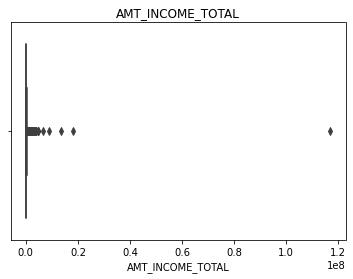

C:\Users\haris\anaconda3\envs\keras\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


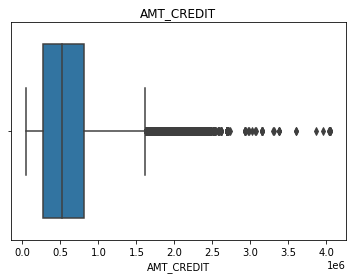

C:\Users\haris\anaconda3\envs\keras\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


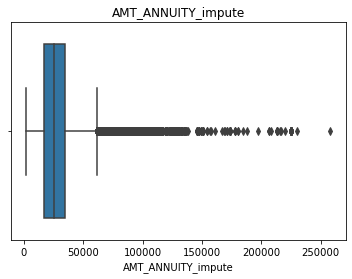

C:\Users\haris\anaconda3\envs\keras\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


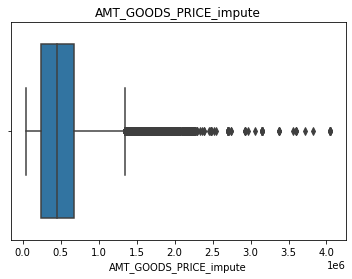

In [61]:
for col in high_mean_col:
    sns.boxplot(loan_df[col])
    plt.title(col)
    plt.show()

**All values are right skewd**

In [62]:

def outlierDetails(col, limits):
    try:
        if((type(limits) == float) or (type(limits) == int)):
            lower_quantile = limits
            upper_quantile = 1 - limits
        else:
            lower_quantile = limits[0]
            upper_quantile = limits[1]
    
        iqr = loan_df[col].quantile(upper_quantile)-loan_df[col].quantile(lower_quantile)
        lower_bond = loan_df[col].quantile(lower_quantile)-(1.5*iqr)
        upper_bond = loan_df[col].quantile(upper_quantile)+(1.5*iqr)
        outlier_percentage = loan_df[col].loc[((loan_df[col] < lower_bond) | (loan_df[col] > upper_bond))].shape[0] / loan_df.shape[0]
        
        return (lower_bond, upper_bond, outlier_percentage)
    except Exception as e:
        print("Error:-",e)

In [63]:
# Creating function for log transformatio
def logTransform(col, new_col):
    loan_df[new_col] = np.log(loan_df[col])

In [64]:
# Creating function for winsorizing the outliers
from scipy.stats.mstats import winsorize
def winsorizing(col, new_col, limits):
    loan_df[new_col] = winsorize(loan_df[col], limits=limits)

**Performing log transformation it will handle outliers by transforming values in low range. Applying winsorizing with 0.25 and 0.75 limit which will replace outlier values with 0.25 or 0.75 quantile value**

In [65]:
limits = [0.25,0.75]
for col in high_mean_col:
    logTransform(col,col+'_log')
    outlier_details = outlierDetails(col+'_log',limits)
    print(f"{col} Outlier Details After Log Transformation {outlier_details}")
    print("-----------------------------------------------------------------")
    if(outlier_details[2] > 0):
        winsorizing(col,col+'_win',limits)
        outlier_details = outlierDetails(col+'_win',limits)
        print(f"{col} Outlier Details After Winsorizing {outlier_details}")
        print("===========================================================")
        loan_df.drop(col+'_log',axis=1,inplace=True)
    loan_df.drop(col, axis=1,inplace=True)

AMT_INCOME_TOTAL Outlier Details After Log Transformation (10.749028503273435, 13.100175162881909, 0.02143337961894046)
-----------------------------------------------------------------
AMT_INCOME_TOTAL Outlier Details After Winsorizing (112500.0, 112500.0, 0.0)
AMT_CREDIT Outlier Details After Log Transformation (10.860760890629392, 15.248537816899043, 0.003102328046801578)
-----------------------------------------------------------------
AMT_CREDIT Outlier Details After Winsorizing (270000.0, 270000.0, 0.0)
AMT_ANNUITY_impute Outlier Details After Log Transformation (8.604182850152032, 11.559879645791025, 0.007297299933986101)
-----------------------------------------------------------------
AMT_ANNUITY_impute Outlier Details After Winsorizing (16524.0, 16524.0, 0.0)
AMT_GOODS_PRICE_impute Outlier Details After Log Transformation (10.811642704416332, 14.999594397467536, 0.004373827277723398)
-----------------------------------------------------------------
AMT_GOODS_PRICE_impute Outl

In [66]:
loan_df.shape

(307511, 121)

In [67]:
low_mean_col = num_cols.drop(high_mean_col)
num_cols = num_cols.drop(high_mean_col)

In [68]:
# Analyzing data of low mean col
loan_df[low_mean_col].describe().T

,count,mean,std,min,25%,50%,75%,max
REGION_POPULATION_RELATIVE,307511.0,0.020868,0.013831,2.900000e-04,0.010006,0.018850,0.028663,0.072508
EXT_SOURCE_1,307511.0,0.502130,0.139395,1.456813e-02,0.502130,0.502130,0.502130,0.962693
APARTMENTS_AVG,307511.0,0.117440,0.075961,0.000000e+00,0.089700,0.117440,0.117440,1.000000
BASEMENTAREA_AVG,307511.0,0.088442,0.053097,0.000000e+00,0.086300,0.088442,0.088442,1.000000
YEARS_BUILD_AVG,307511.0,0.752471,0.065567,0.000000e+00,0.752471,0.752471,0.752471,1.000000
COMMONAREA_AVG,307511.0,0.044621,0.041735,0.000000e+00,0.044621,0.044621,0.044621,1.000000
ELEVATORS_AVG,307511.0,0.078942,0.091970,0.000000e+00,0.000000,0.078942,0.078942,1.000000
ENTRANCES_AVG,307511.0,0.149725,0.070498,0.000000e+00,0.137900,0.149725,0.149725,1.000000
FLOORSMIN_AVG,307511.0,0.231894,0.091506,0.000000e+00,0.231894,0.231894,0.231894,1.000000
LANDAREA_AVG,307511.0,0.066333,0.051743,0.000000e+00,0.062900,0.066333,0.066333,1.000000


**All values are laying b/w 0-1**

## Data Visualization

### 1. Categorical values effect on target

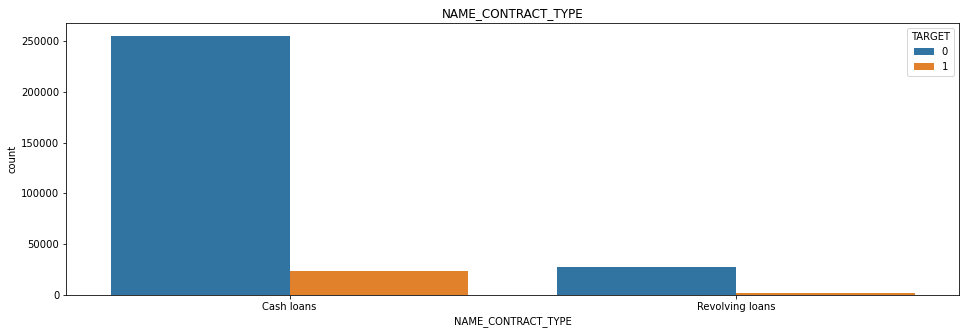

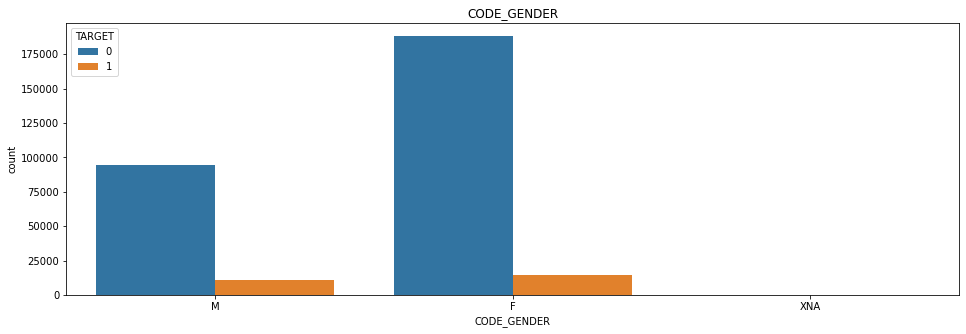

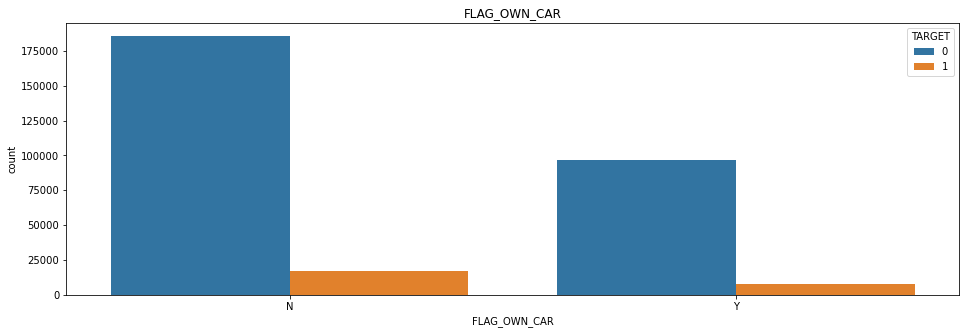

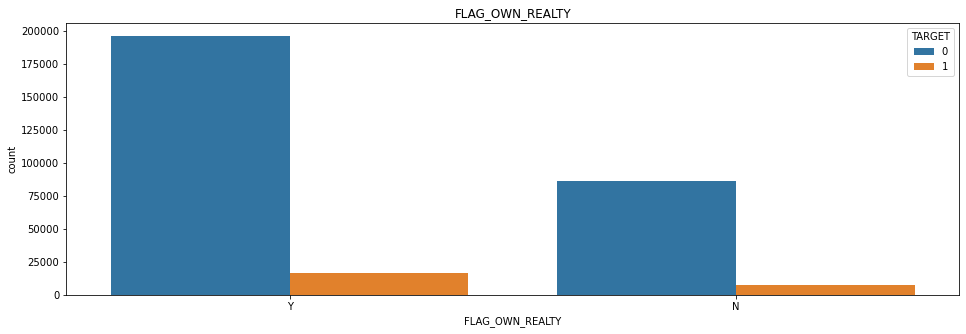

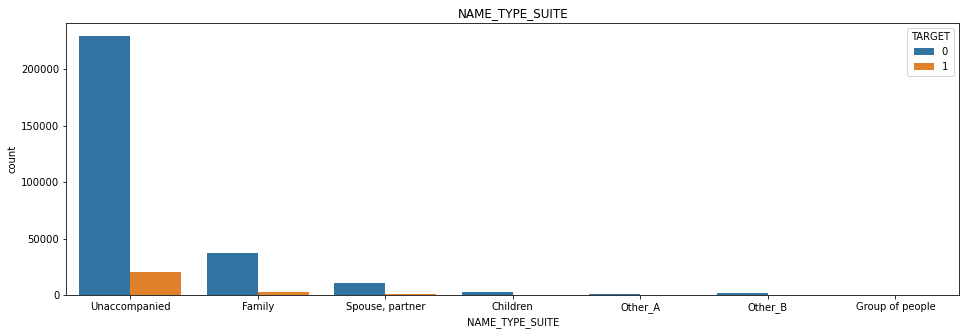

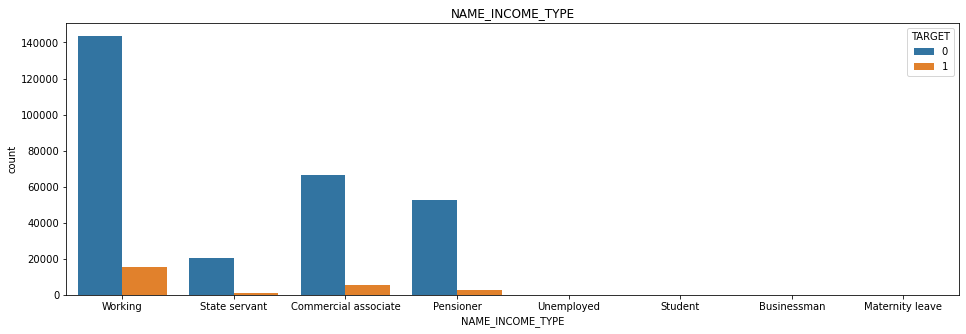

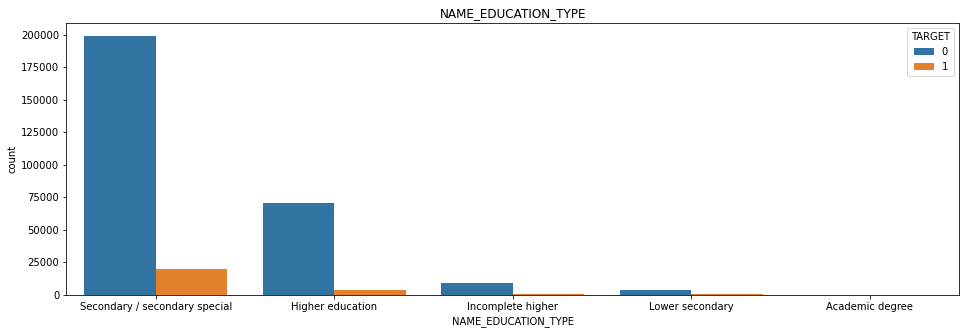

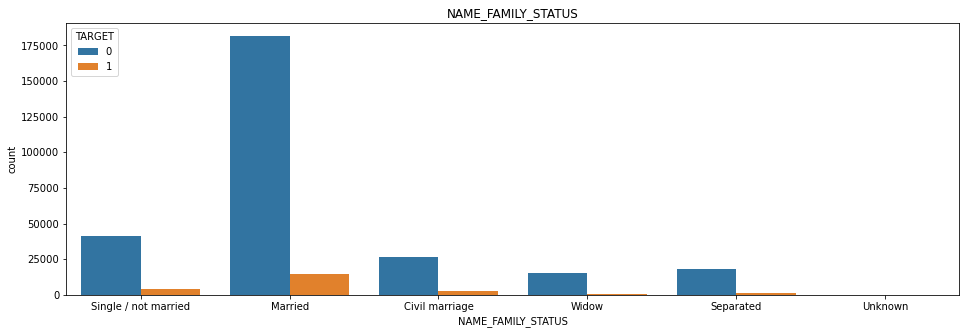

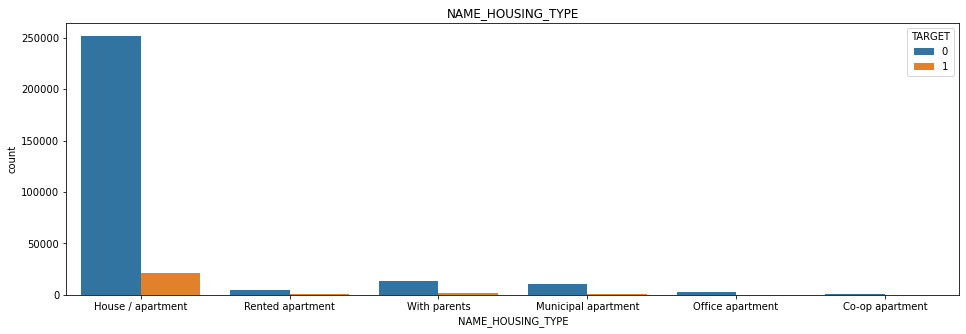

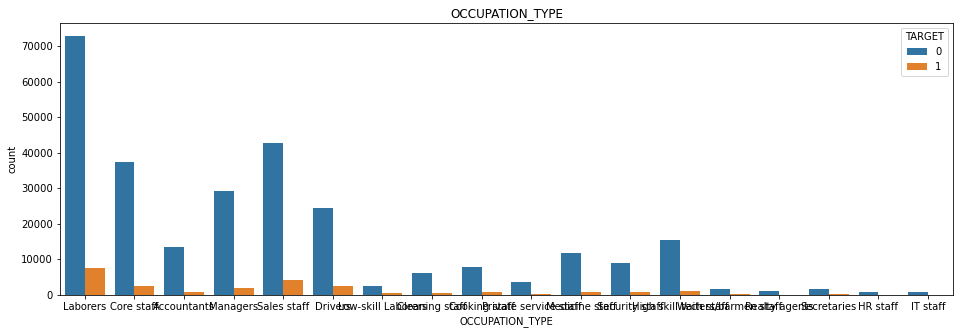

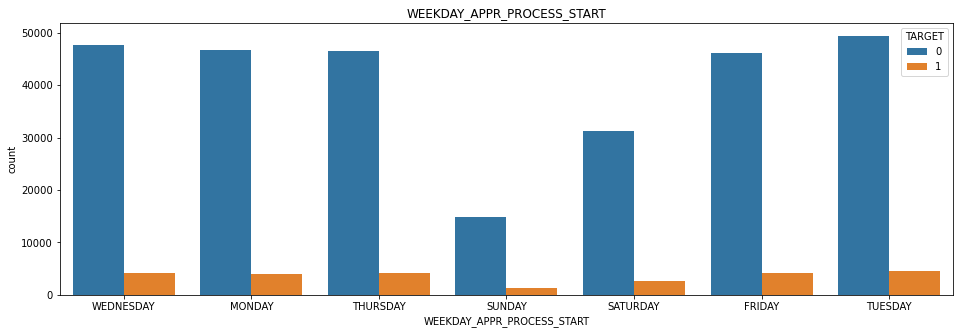

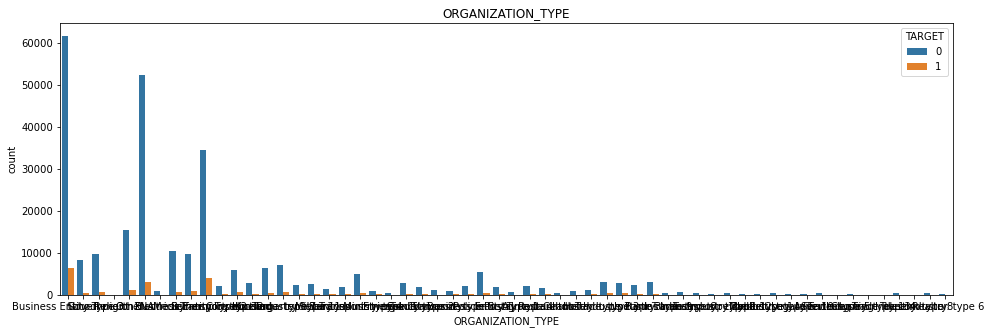

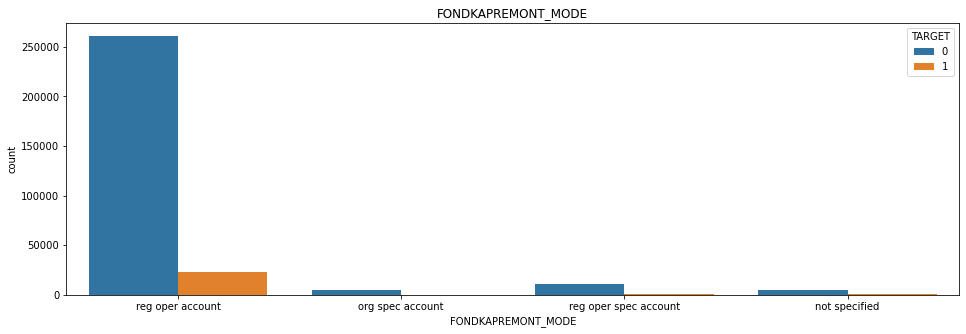

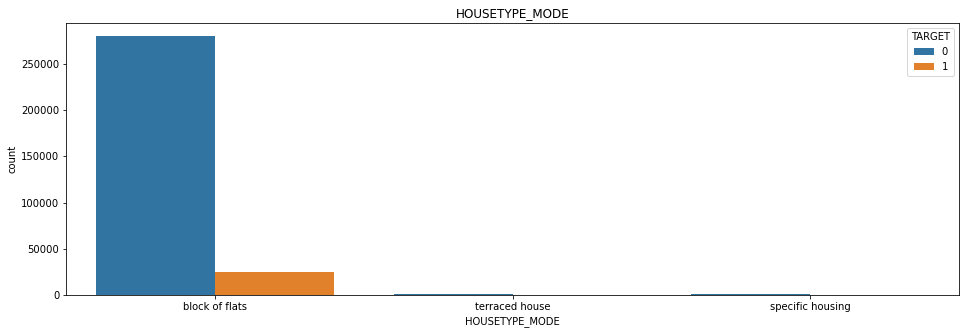

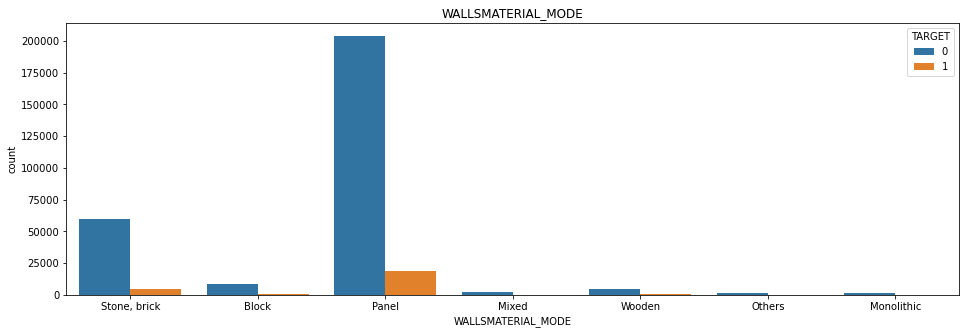

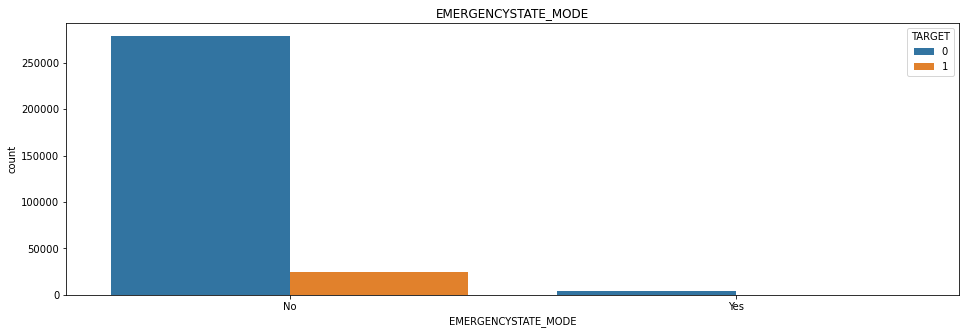

In [69]:
for col in cat_col:
    plt.figure(figsize=(16,5))
    sns.countplot(x=loan_df[col], hue=loan_df['TARGET'])
    plt.title(col)
    plt.show()

**We can make any assumption by looking above charts because in every chart defaulters are incresing if loans on that category is increasing**

### 2. Numeric categorical effects on target

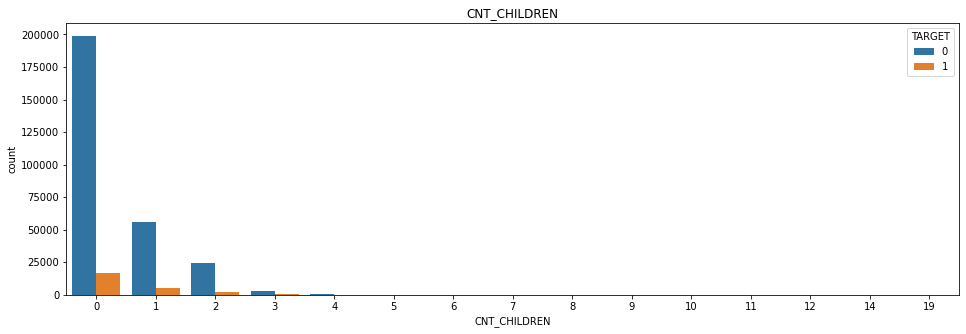

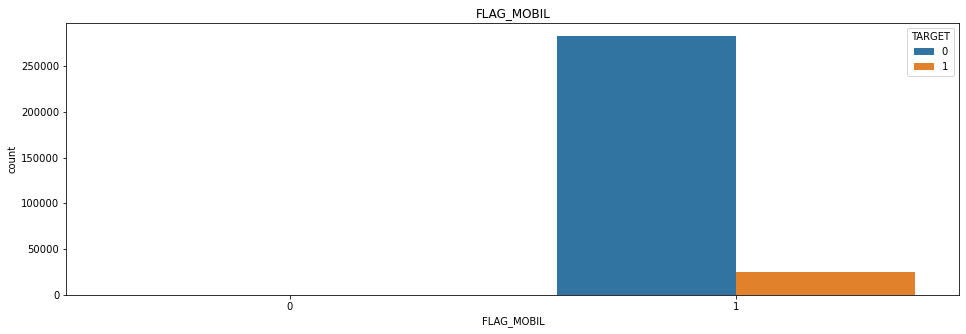

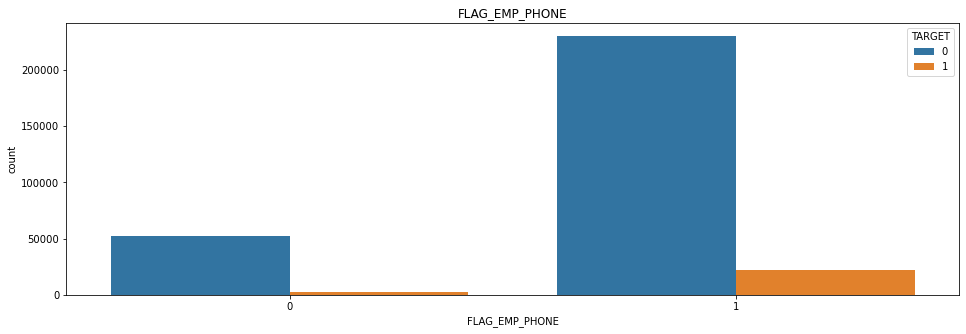

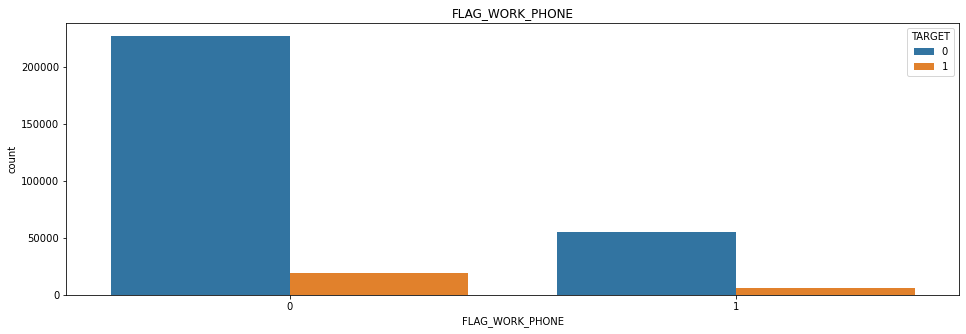

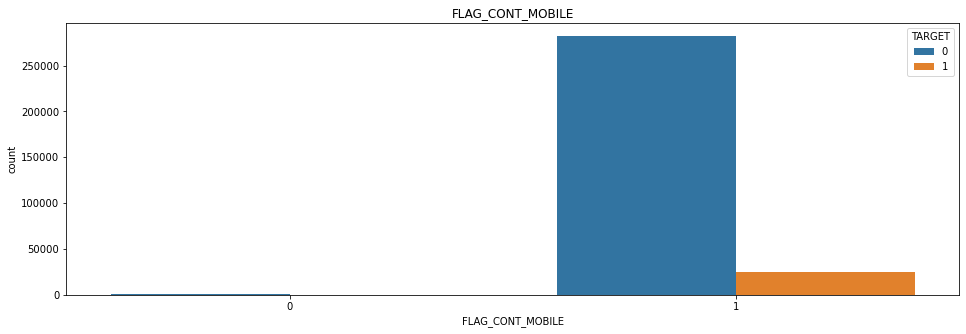

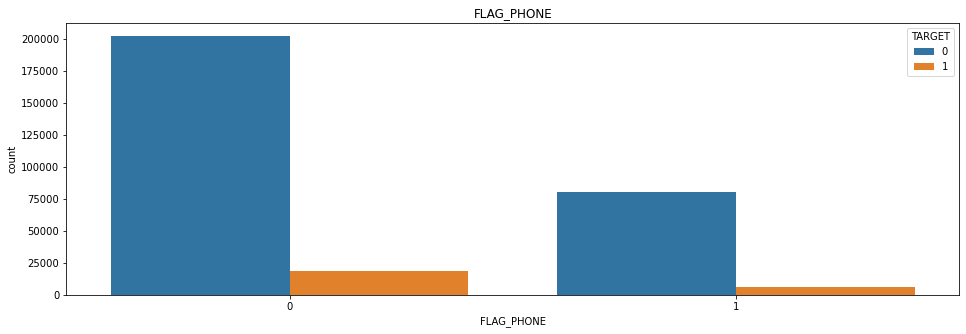

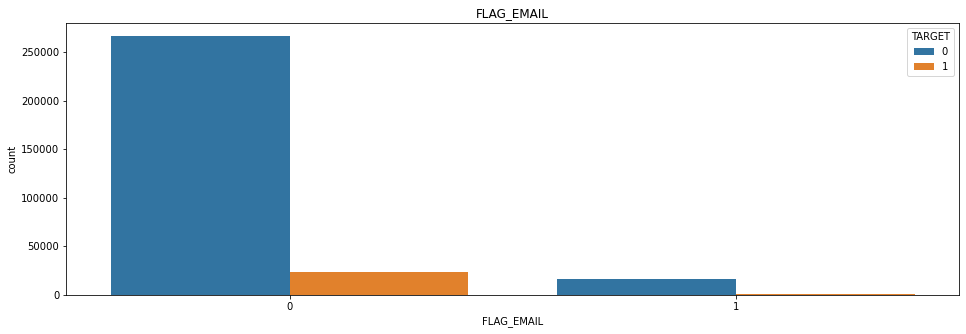

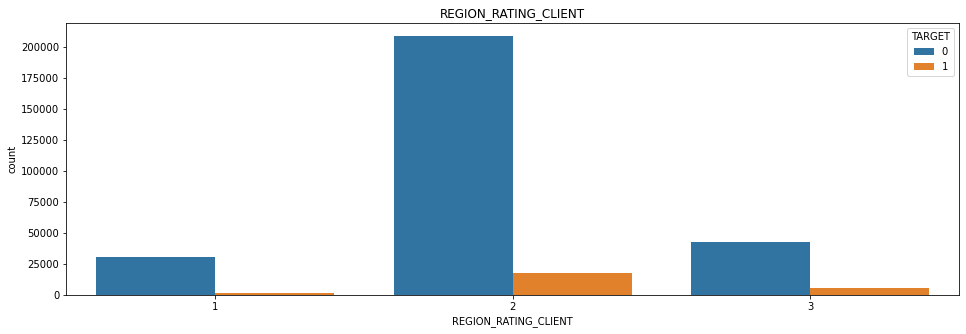

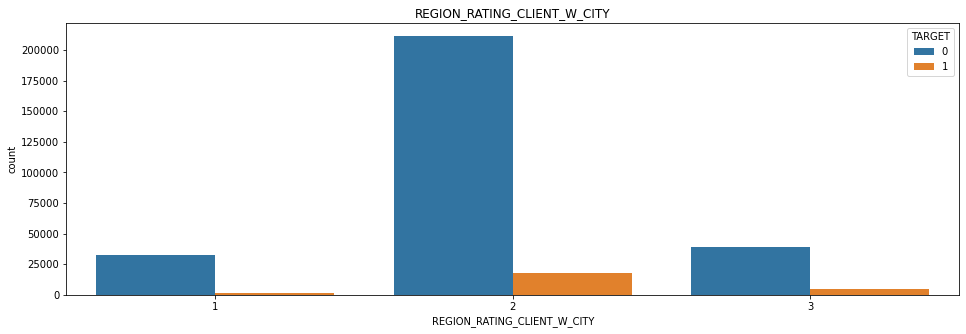

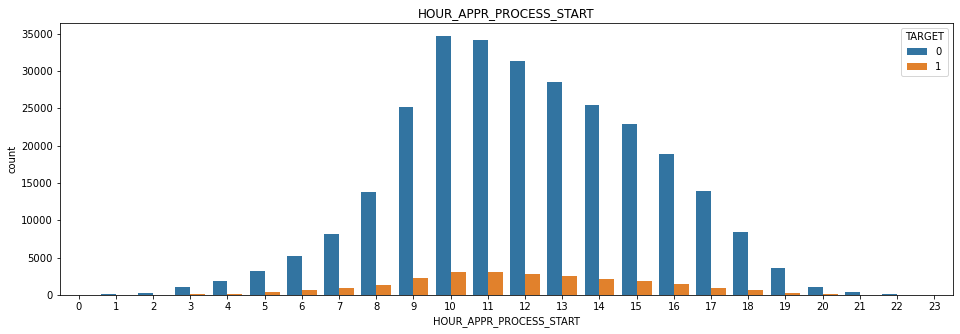

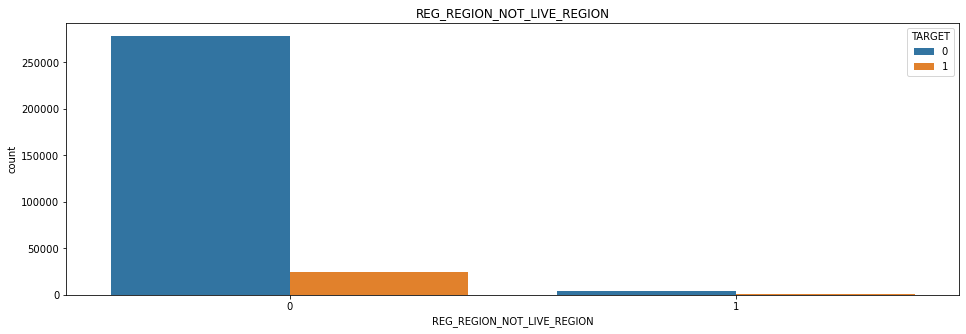

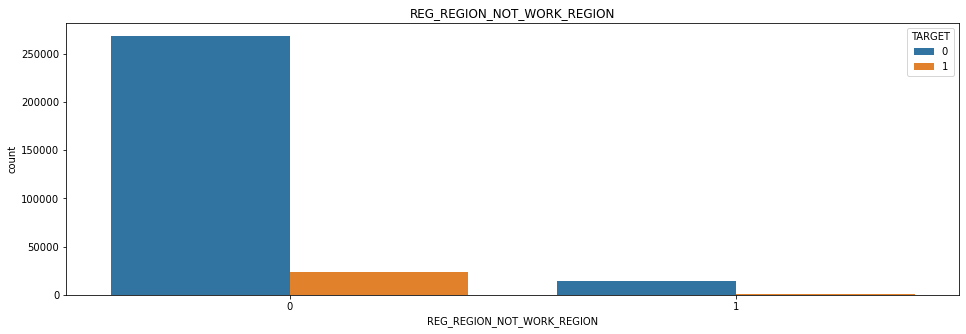

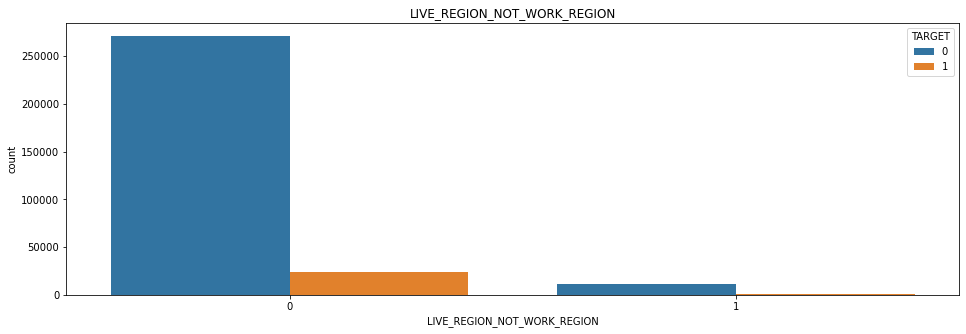

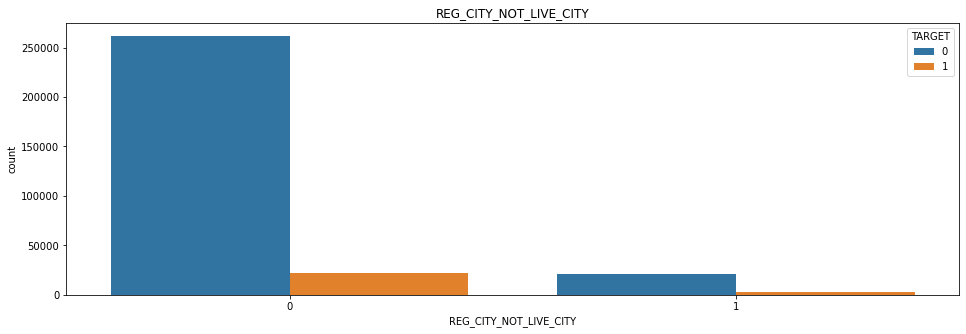

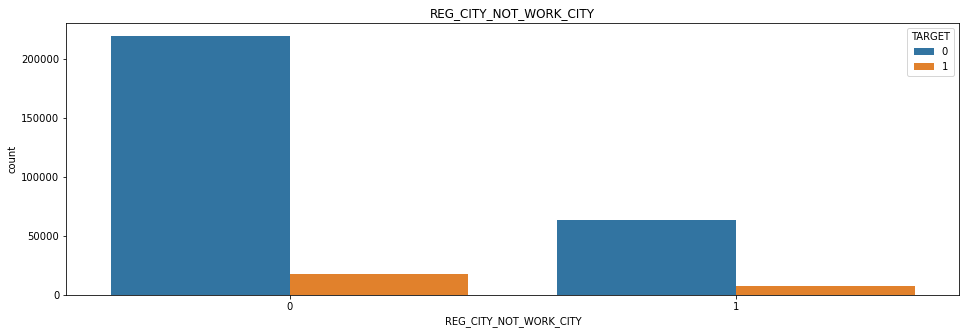

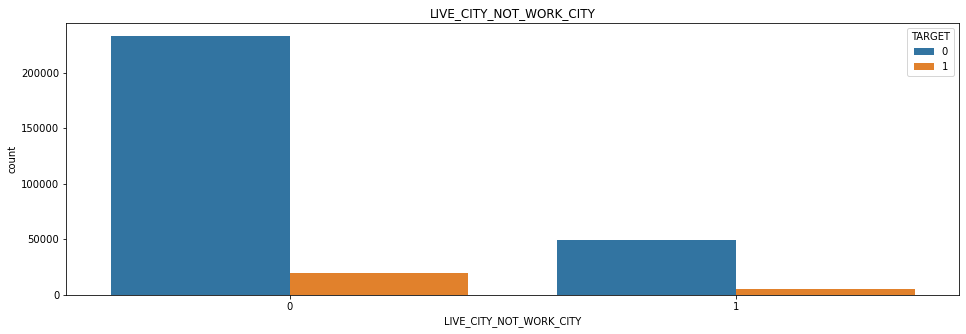

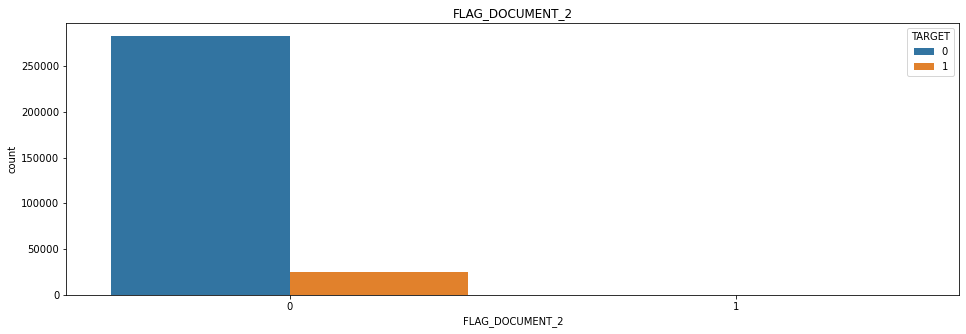

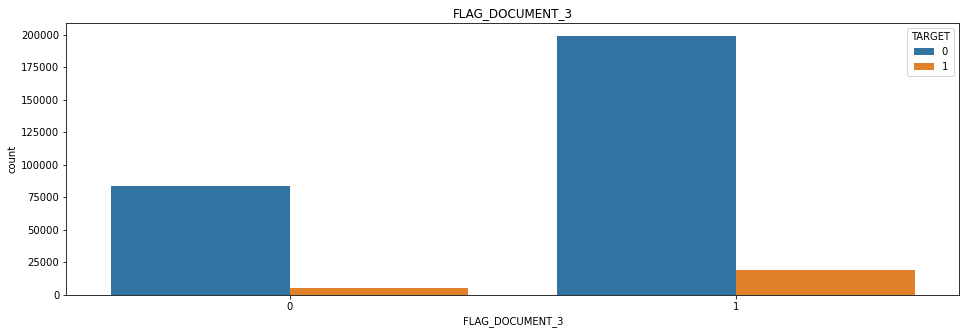

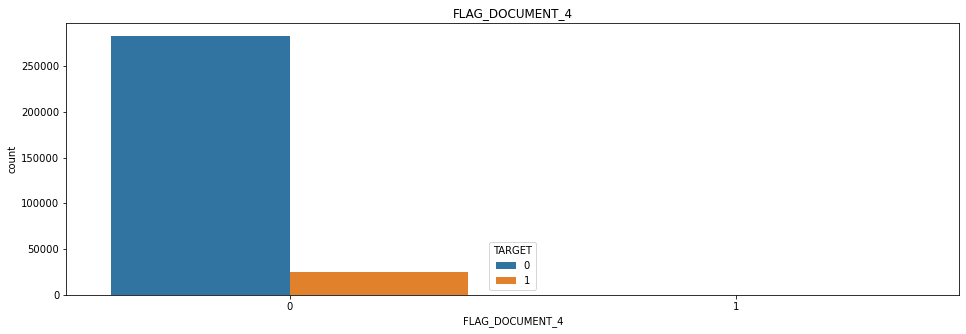

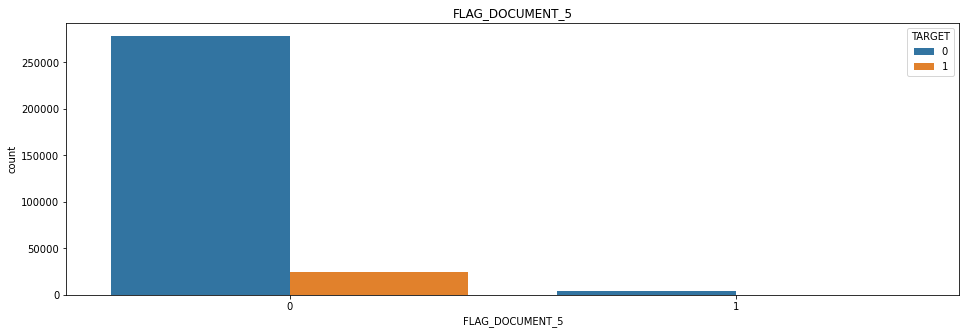

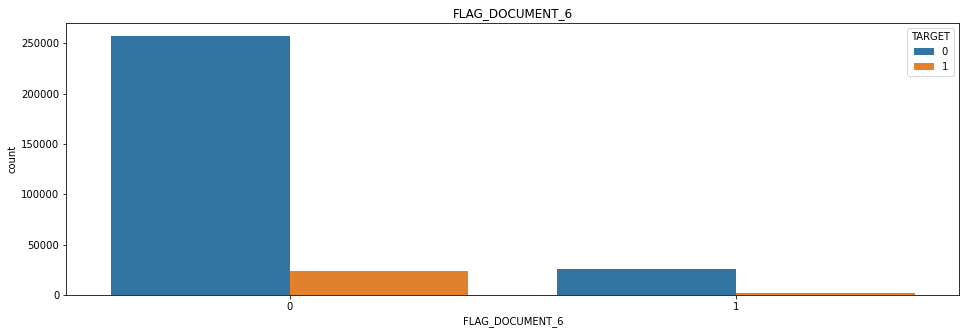

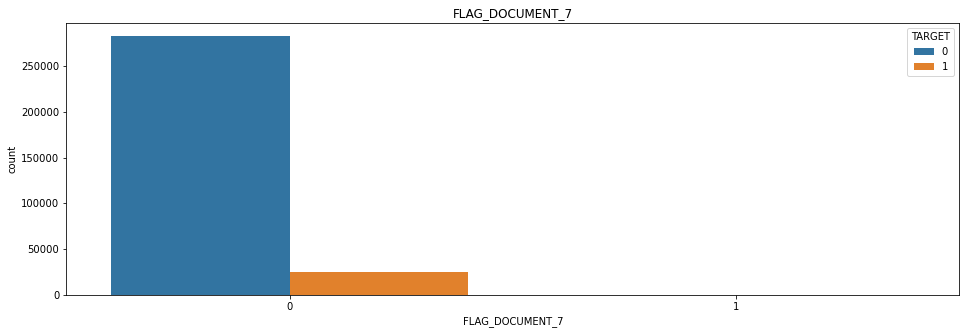

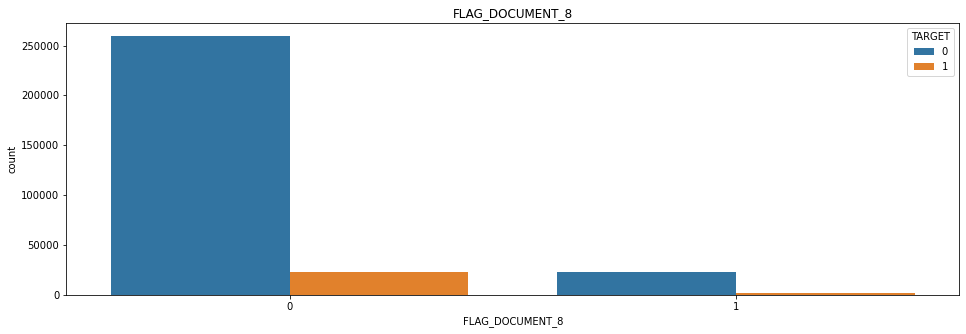

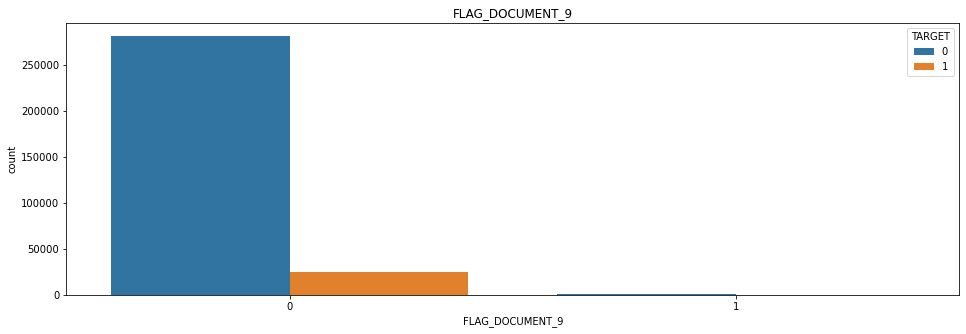

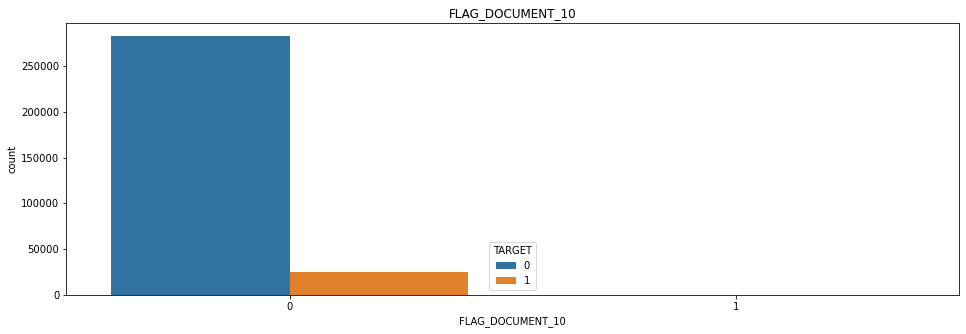

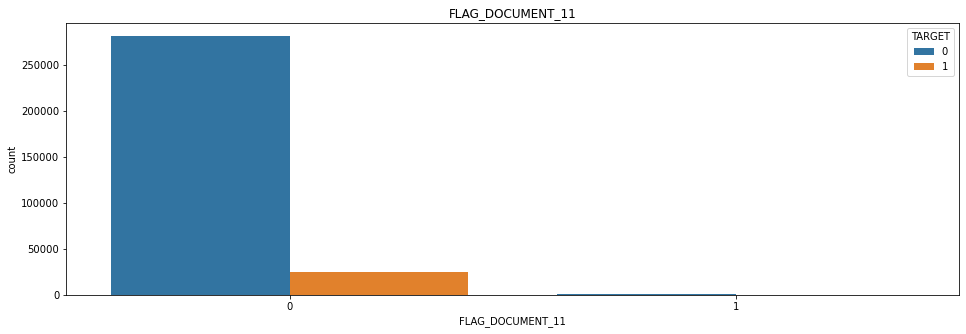

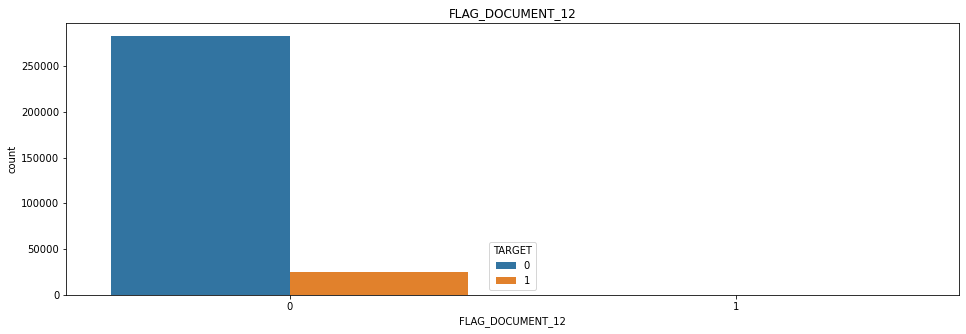

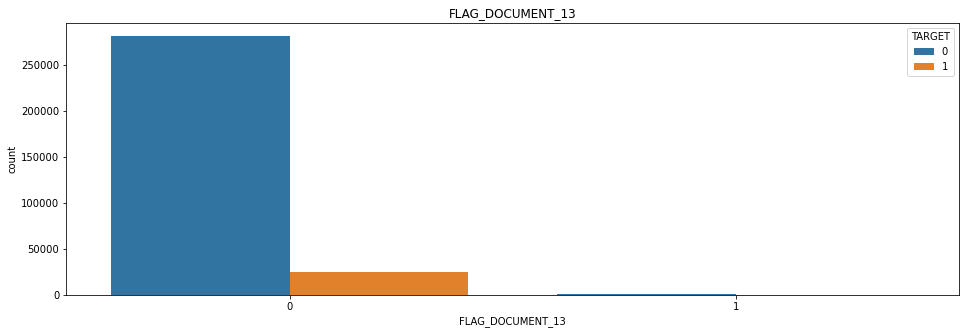

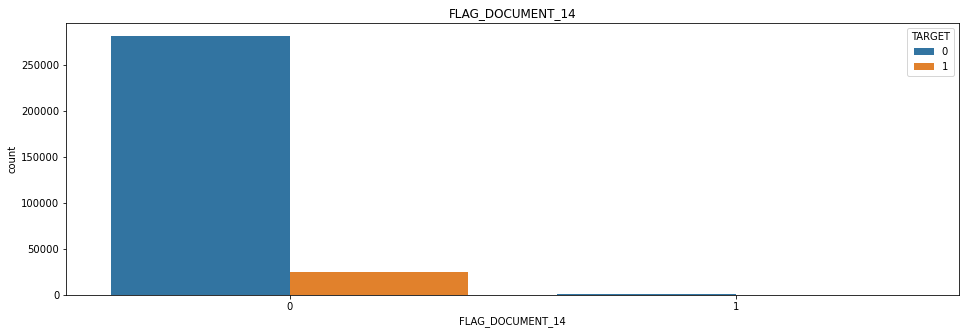

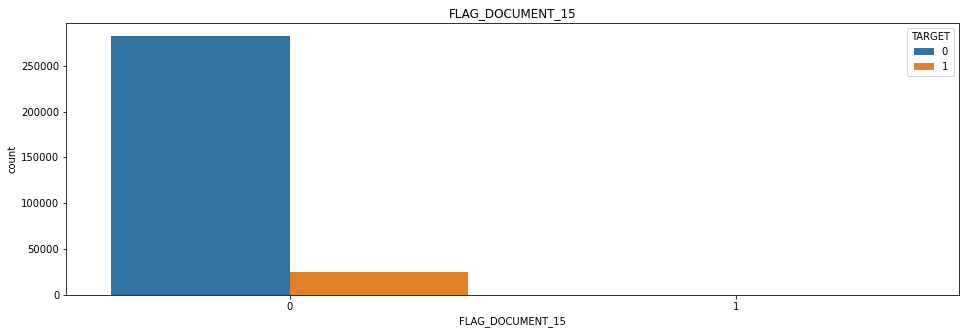

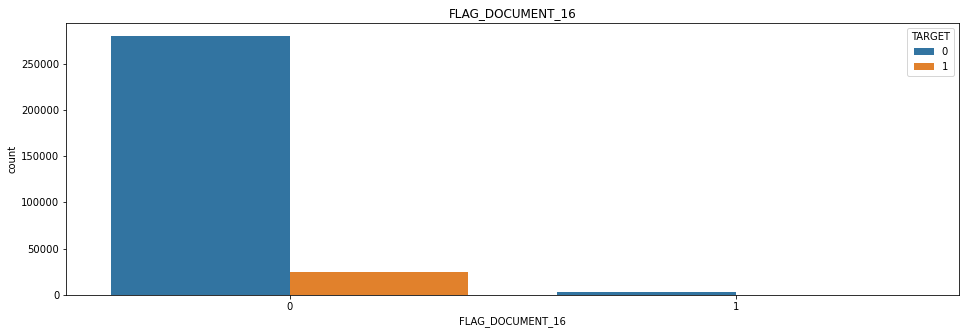

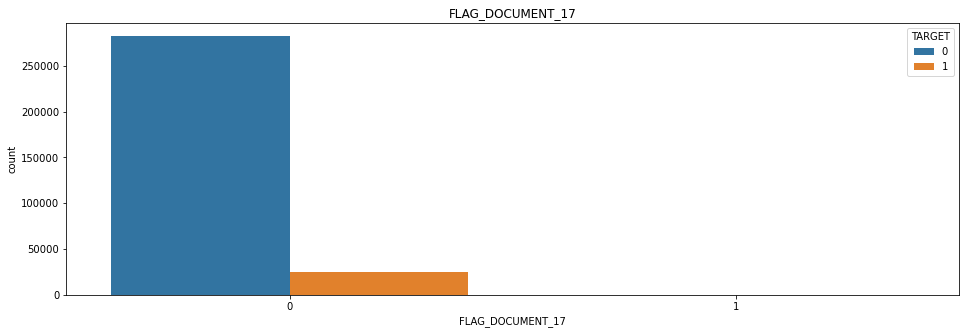

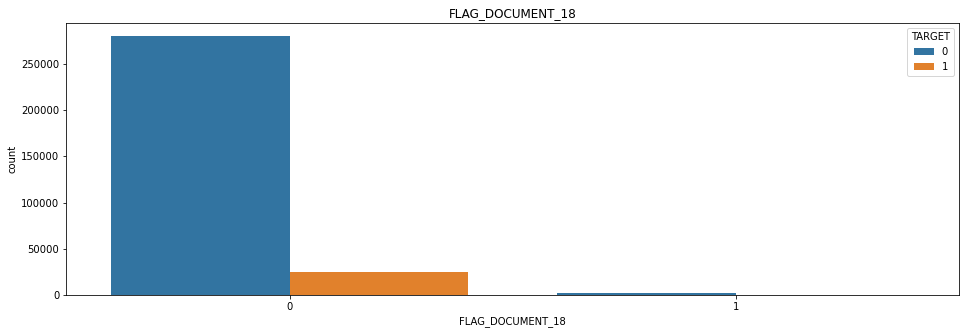

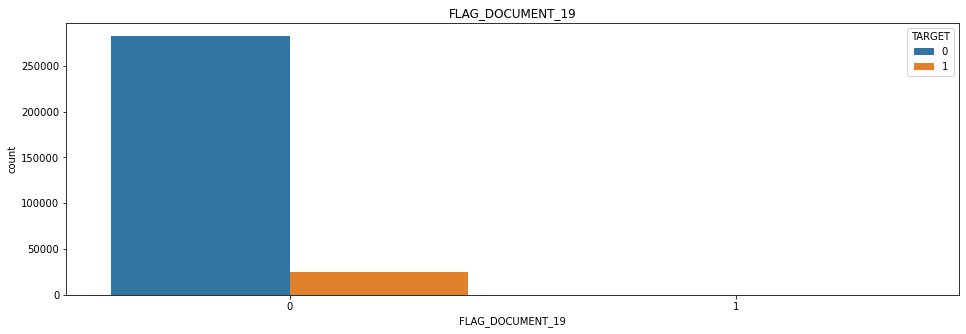

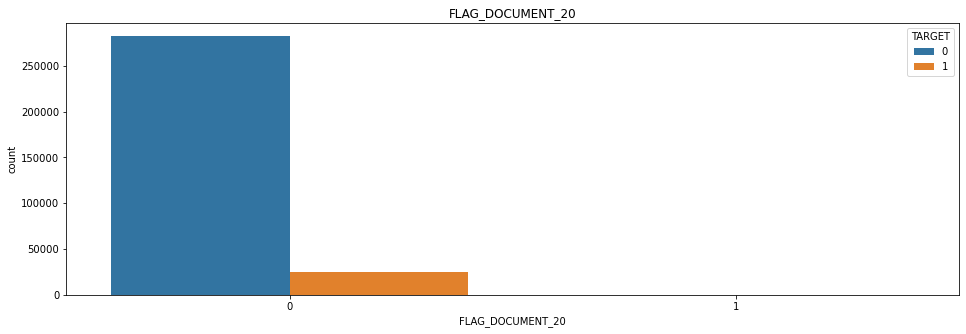

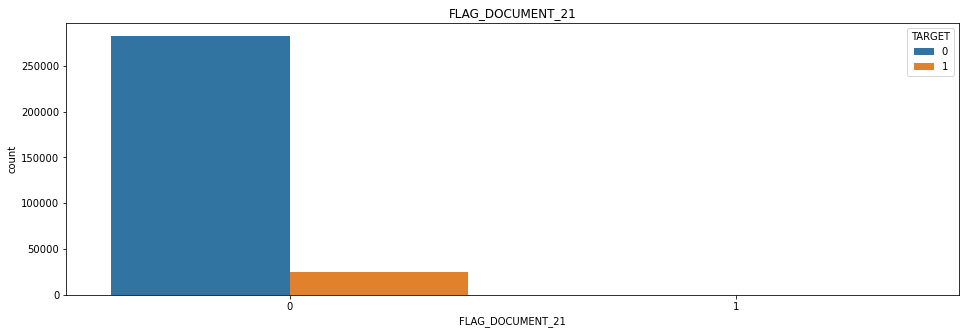

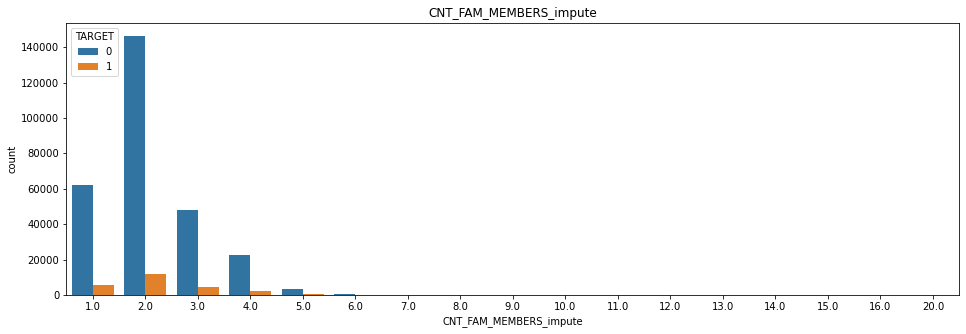

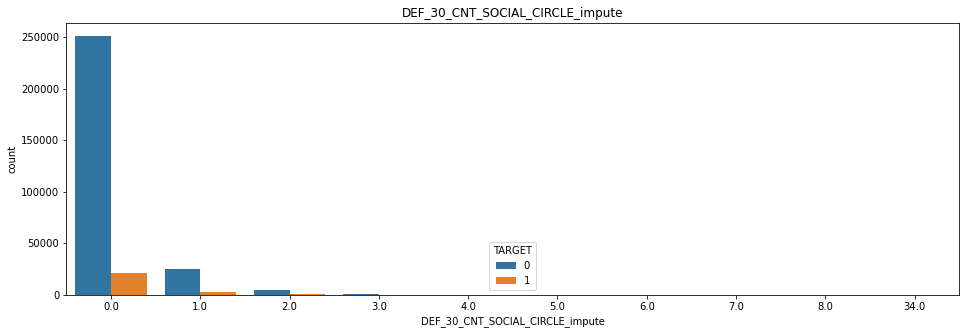

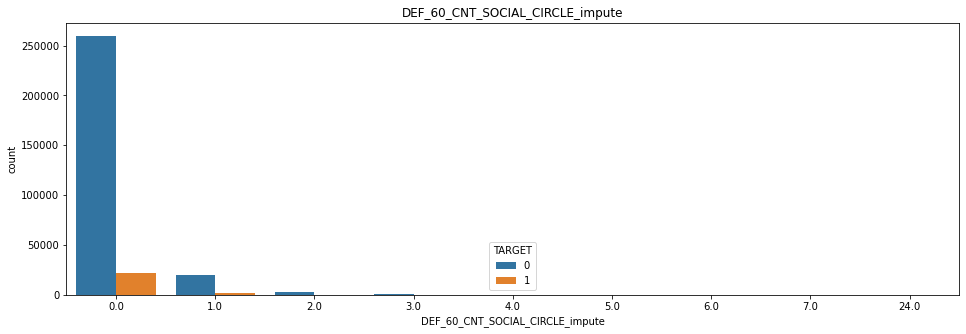

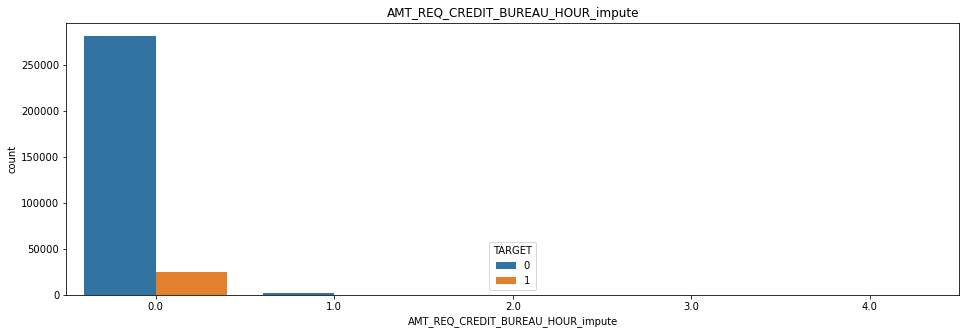

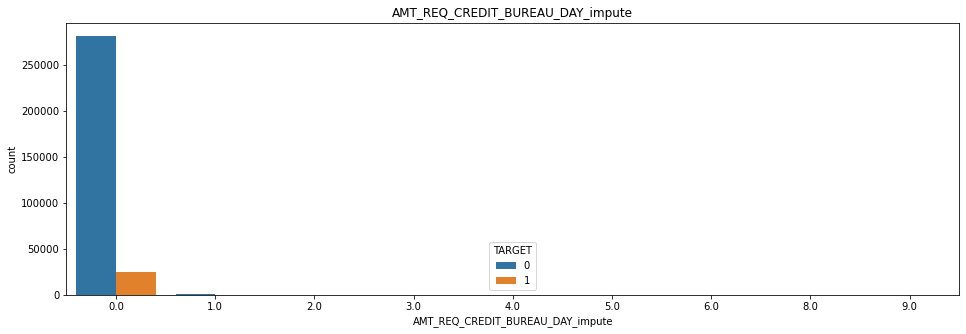

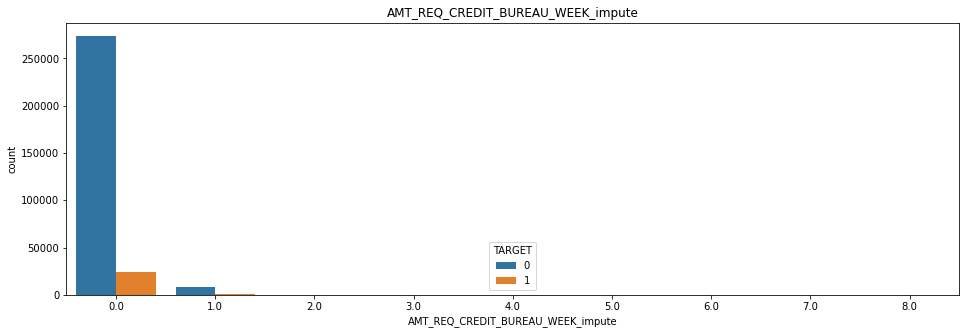

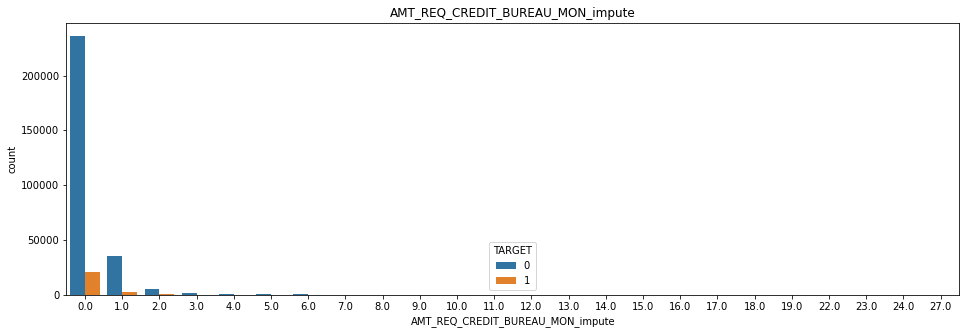

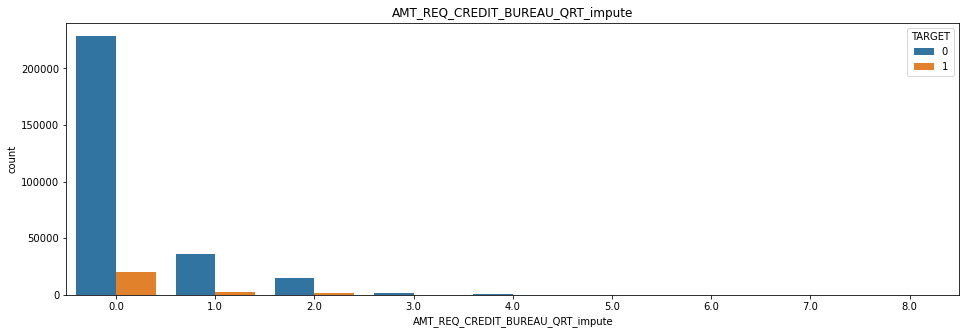

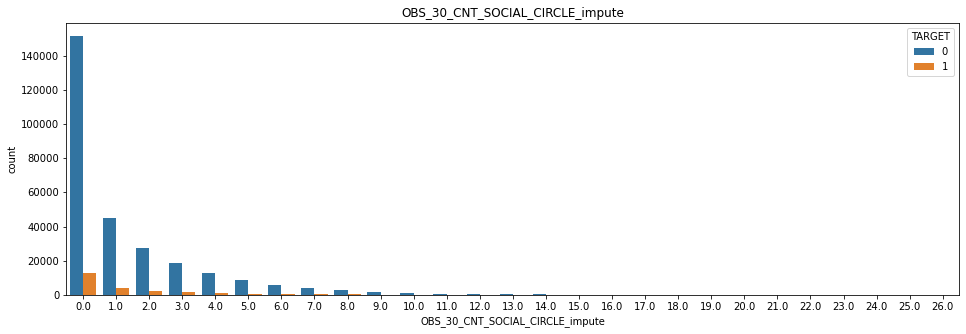

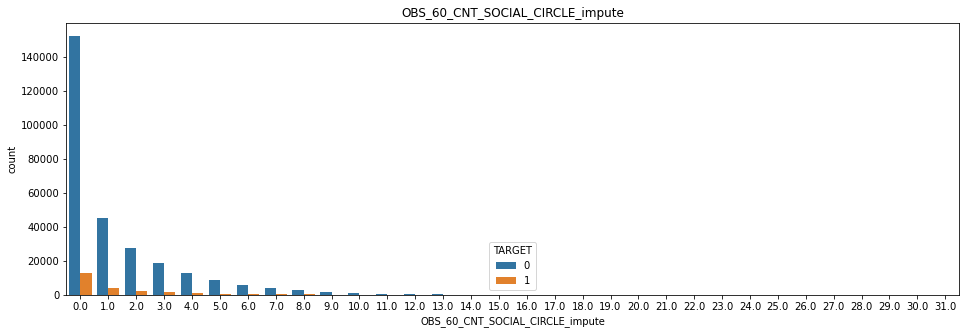

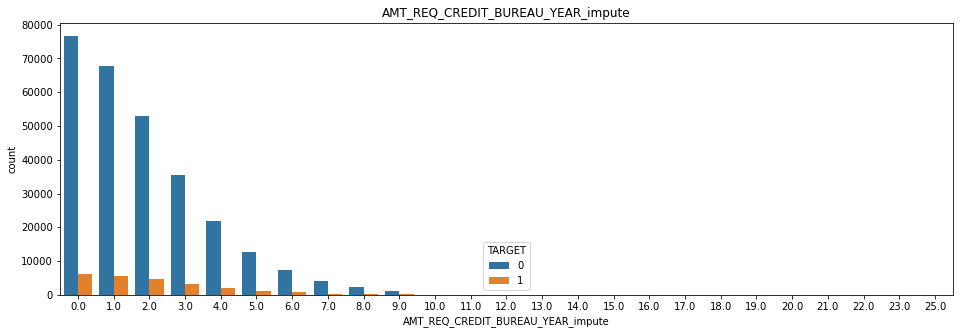

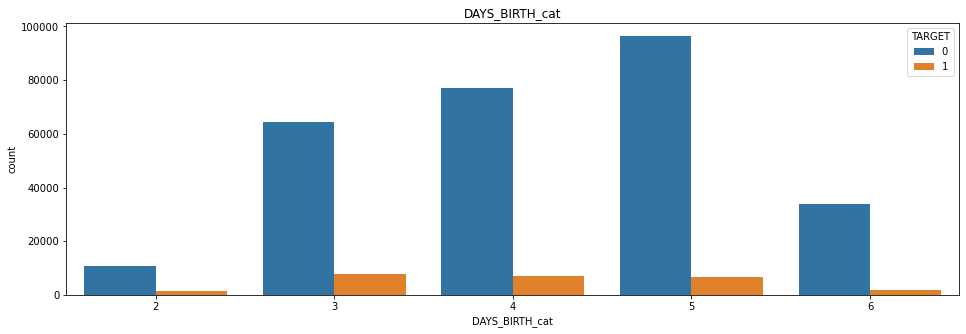

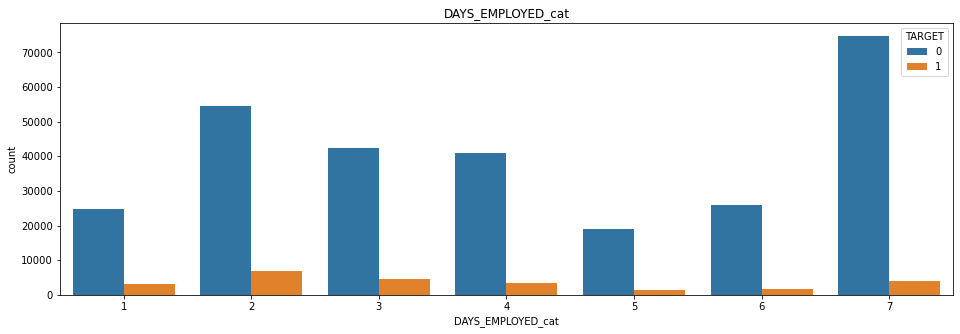

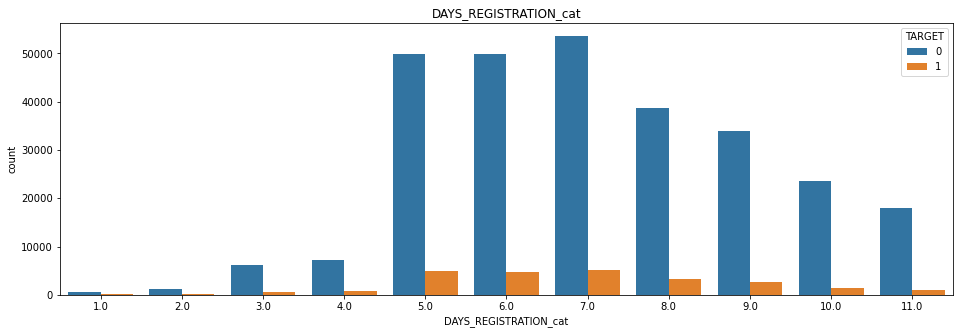

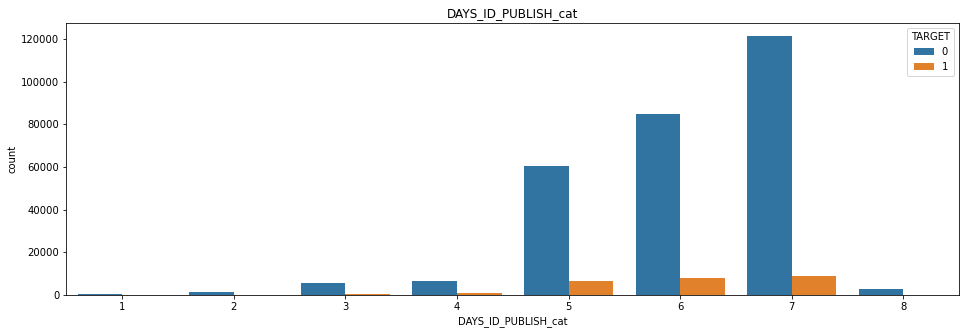

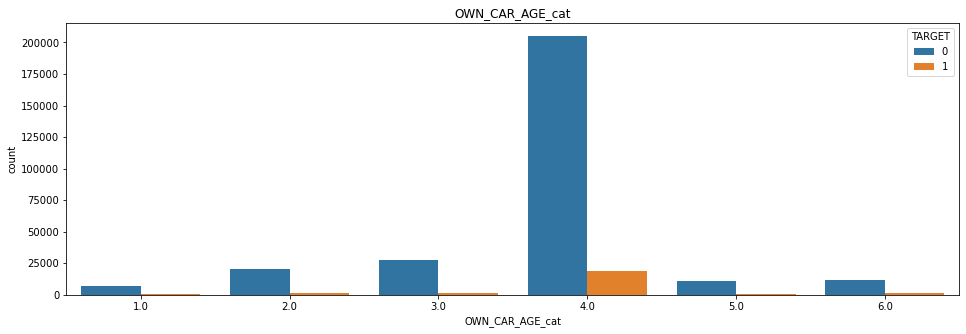

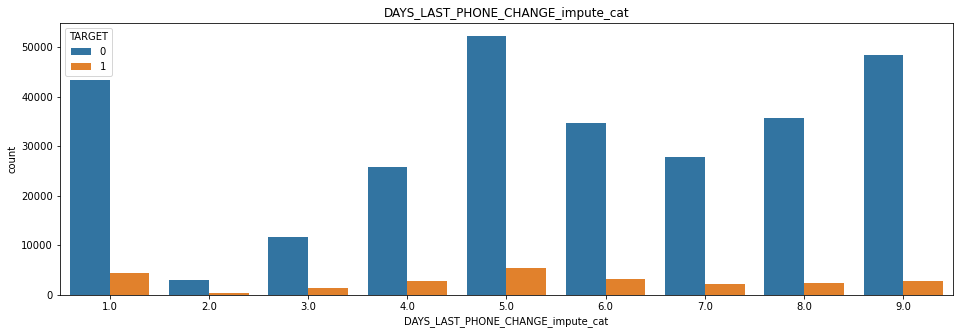

In [70]:
for col in expected_num_cat_cols:
    plt.figure(figsize=(16,5))
    sns.countplot(x=loan_df[col], hue=loan_df['TARGET'])
    plt.title(col)
    plt.show()

**Same as categorical features number of defaulters are increasing with total number of loans**

In [71]:
# Creating checkpoint
loan_df1 = loan_df.copy()

## Categorical feature encoding

In [72]:
cat_col

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')

In [73]:
with_2_cat_col = []
for col in cat_col:
    print(col)
    print(loan_df[col].unique())
    if(loan_df[col].unique().shape[0] == 2):
        with_2_cat_col.append(col)
    print("===================")

NAME_CONTRACT_TYPE
['Cash loans' 'Revolving loans']
CODE_GENDER
['M' 'F' 'XNA']
FLAG_OWN_CAR
['N' 'Y']
FLAG_OWN_REALTY
['Y' 'N']
NAME_TYPE_SUITE
['Unaccompanied' 'Family' 'Spouse, partner' 'Children' 'Other_A' 'Other_B'
 'Group of people']
NAME_INCOME_TYPE
['Working' 'State servant' 'Commercial associate' 'Pensioner' 'Unemployed'
 'Student' 'Businessman' 'Maternity leave']
NAME_EDUCATION_TYPE
['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
NAME_FAMILY_STATUS
['Single / not married' 'Married' 'Civil marriage' 'Widow' 'Separated'
 'Unknown']
NAME_HOUSING_TYPE
['House / apartment' 'Rented apartment' 'With parents'
 'Municipal apartment' 'Office apartment' 'Co-op apartment']
OCCUPATION_TYPE
['Laborers' 'Core staff' 'Accountants' 'Managers' 'Sales staff' 'Drivers'
 'Low-skill Laborers' 'Cleaning staff' 'Cooking staff'
 'Private service staff' 'Medicine staff' 'Security staff'
 'High skill tech staff' 'Waiters/barmen staff' 'Realt

**Applying 1 hot encoding in binomial categorial features**

In [74]:
enc_data = pd.get_dummies(loan_df[with_2_cat_col], drop_first=True)

In [75]:
loan_df = loan_df.join(enc_data)

In [77]:
# Droping with_2_cat_col cols from dataset
loan_df.drop(with_2_cat_col, axis=1, inplace=True)

In [78]:
loan_df.shape

(307511, 121)

In [79]:
cat_col = cat_col.drop(with_2_cat_col)

In [80]:
cat_col

Index(['CODE_GENDER', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE',
       'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE'],
      dtype='object')

In [81]:
# CODE_GENDER has 3 values doing OHE
gender_en = pd.get_dummies(loan_df['CODE_GENDER'], drop_first=True)

In [82]:
loan_df = loan_df.join(gender_en)
loan_df.drop('CODE_GENDER',axis=1, inplace=True)

In [83]:
cat_col = cat_col.drop('CODE_GENDER')

In [84]:
binary_enc_col = ['NAME_TYPE_SUITE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','OCCUPATION_TYPE','ORGANIZATION_TYPE','FONDKAPREMONT_MODE']
label_enc_col = {'NAME_INCOME_TYPE': {'Student':0, 'Unemployed':1, 'Pensioner':2, 'Maternity leave':3, 'Working':4, 'Businessman':5,'State servant':6}
                 ,'NAME_EDUCATION_TYPE': {'Lower secondary':0, 'Secondary / secondary special':1, 'Academic degree':2, 'Incomplete higher':3, 'Higher education':4},
                 'HOUSETYPE_MODE': {'block of flats':0, 'terraced house':1, 'specific housing':2},
                 'WALLSMATERIAL_MODE': {'Stone, brick':0, 'Block':1, 'Panel':2, 'Mixed':3, 'Wooden':4, 'Others':5, 'Monolithic':6},
                 "WEEKDAY_APPR_PROCESS_START": {'MONDAY':0, 'TUESDAY':1, 'WEDNESDAY':2, 'THURSDAY':3, 'FRIDAY':4, 'SATURDAY': 5, 'SUNDAY':6}
                }

In [85]:
for col,val in label_enc_col.items():
    loan_df[col] = loan_df[col].map(val)

In [86]:
loan_df[label_enc_col].head()

,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,WEEKDAY_APPR_PROCESS_START
0,4.0,1,0,0,2
1,6.0,4,0,1,0
2,4.0,1,0,2,0
3,4.0,1,0,2,2
4,4.0,1,0,2,3


In [88]:
from category_encoders.binary import BinaryEncoder

bi_en = BinaryEncoder()
bin_data = bi_en.fit_transform(loan_df[binary_enc_col])
bin_data.head()

C:\Users\haris\anaconda3\envs\keras\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,NAME_TYPE_SUITE_0,NAME_TYPE_SUITE_1,NAME_TYPE_SUITE_2,NAME_TYPE_SUITE_3,NAME_FAMILY_STATUS_0,NAME_FAMILY_STATUS_1,NAME_FAMILY_STATUS_2,NAME_FAMILY_STATUS_3,NAME_HOUSING_TYPE_0,NAME_HOUSING_TYPE_1,...,ORGANIZATION_TYPE_0,ORGANIZATION_TYPE_1,ORGANIZATION_TYPE_2,ORGANIZATION_TYPE_3,ORGANIZATION_TYPE_4,ORGANIZATION_TYPE_5,ORGANIZATION_TYPE_6,FONDKAPREMONT_MODE_0,FONDKAPREMONT_MODE_1,FONDKAPREMONT_MODE_2
0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
1,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,1,1,0,0,1
3,0,0,0,1,0,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1
4,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1


In [89]:
loan_df = loan_df.join(bin_data)

In [90]:
loan_df.drop(cat_col, axis=1, inplace=True)

In [91]:
loan_df.shape

(307511, 139)

In [92]:
loan_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 139 columns):
 #    Column                               Dtype  
---   ------                               -----  
 0    TARGET                               int64  
 1    CNT_CHILDREN                         int64  
 2    REGION_POPULATION_RELATIVE           float64
 3    FLAG_MOBIL                           int64  
 4    FLAG_EMP_PHONE                       int64  
 5    FLAG_WORK_PHONE                      int64  
 6    FLAG_CONT_MOBILE                     int64  
 7    FLAG_PHONE                           int64  
 8    FLAG_EMAIL                           int64  
 9    REGION_RATING_CLIENT                 int64  
 10   REGION_RATING_CLIENT_W_CITY          int64  
 11   HOUR_APPR_PROCESS_START              int64  
 12   REG_REGION_NOT_LIVE_REGION           int64  
 13   REG_REGION_NOT_WORK_REGION           int64  
 14   LIVE_REGION_NOT_WORK_REGION          int64  
 15   REG_CITY_NOT_LI

## ----------------- All Features are converted into Numbers --------------------

## Checking for Target features

C:\Users\haris\anaconda3\envs\keras\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


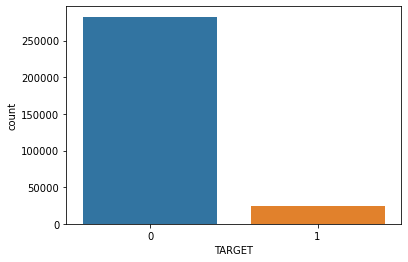

In [93]:
sns.countplot(loan_df['TARGET'])
plt.show()

**We can clearly see that data is imbalanced**

## Applying Oversampling Technique SMOTE

In [95]:
X = loan_df.drop('TARGET', axis=1)
y = loan_df['TARGET']

In [97]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy = 'minority')
X_sm, y_sm = smote.fit_sample(X,y)

C:\Users\haris\anaconda3\envs\keras\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


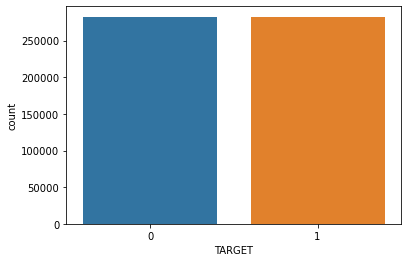

In [98]:
sns.countplot(y_sm)
plt.show()

**Normalizing the dataset**

In [99]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaler = scaler.fit_transform(X_sm)

In [182]:
df_scaler.shape

(565372, 138)

# Model Implementation

### 1. Train Test Split

In [100]:
from sklearn.model_selection import train_test_split

In [192]:
X_train, X_test, y_train, y_test = train_test_split(df_scaler, y_sm, random_state=343)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(424029, 138)
(424029,)
(141343, 138)
(141343,)


## Building ANN model

In [199]:
def buildANNModel(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers',1,5)):
        model.add(layers.Dense(units=hp.Int('units_'+str(i),min_value=100, max_value=500, step=20),
                              activation=hp.Choice('activation',['relu','selu','tanh']),
                              kernel_initializer="he_uniform"))
        model.add(layers.Dropout(hp.Choice('Dropout',[0.1,0.2,0.3])))
    model.add(layers.Dense(1, activation="linear"))
    model.compile(optimizer=keras.optimizers.Adam(
    hp.Choice('learning_rate', [0.0001])),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model

In [204]:
tuner = RandomSearch(
    buildANNModel,
    objective='val_accuracy',
    max_trials=2,
    executions_per_trial=2,
    directory='models1',
    project_name='Bank Loan Application'
)

In [205]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 20, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 100, 'max_value': 500, 'step': 20, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'selu', 'tanh'], 'ordered': False}
Dropout (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.2, 0.3], 'ordered': True}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 100, 'max_value': 500, 'step': 20, 'sampling': None}
learning_rate (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001], 'ordered': True}


In [206]:
tuner.search(X_train, y_train, epochs=60, validation_data=(X_test, y_test))

Trial 2 Complete [03h 04m 24s]
val_accuracy: 0.8597666919231415

Best val_accuracy So Far: 0.9103493094444275
Total elapsed time: 04h 24m 42s
INFO:tensorflow:Oracle triggered exit


In [207]:
tuner.results_summary()

Results summary
Results in models1\Bank Loan Application
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
num_layers: 2
units_0: 380
activation: tanh
Dropout: 0.2
units_1: 160
learning_rate: 0.0001
Score: 0.9103493094444275
Trial summary
Hyperparameters:
num_layers: 14
units_0: 420
activation: relu
Dropout: 0.2
units_1: 260
learning_rate: 0.0001
units_2: 100
units_3: 100
units_4: 100
units_5: 100
units_6: 100
units_7: 100
units_8: 100
units_9: 100
units_10: 100
units_11: 100
units_12: 100
units_13: 100
Score: 0.8597666919231415


In [216]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

In [220]:
model = tuner.hypermodel.build(best_hps)
model.fit(X_train, y_train, epochs = 60, validation_data = (X_test, y_test))

Epoch 1/60
13251/13251 [==============================] - 39s 3ms/step - loss: 2.0104 - accuracy: 0.8029 - val_loss: 1.6270 - val_accuracy: 0.8492
Epoch 2/60
13251/13251 [==============================] - 39s 3ms/step - loss: 1.8449 - accuracy: 0.8363 - val_loss: 1.6304 - val_accuracy: 0.8580
Epoch 3/60
13251/13251 [==============================] - 39s 3ms/step - loss: 1.7935 - accuracy: 0.8420 - val_loss: 1.5736 - val_accuracy: 0.8622
Epoch 4/60
13251/13251 [==============================] - 42s 3ms/step - loss: 1.7159 - accuracy: 0.8497 - val_loss: 1.6491 - val_accuracy: 0.8591
Epoch 5/60
13251/13251 [==============================] - 39s 3ms/step - loss: 1.7133 - accuracy: 0.8506 - val_loss: 1.6770 - val_accuracy: 0.8564
Epoch 6/60
13251/13251 [==============================] - 39s 3ms/step - loss: 1.7150 - accuracy: 0.8508 - val_loss: 1.5144 - val_accuracy: 0.8656
Epoch 7/60
13251/13251 [==============================] - 44s 3ms/step - loss: 1.6086 - accuracy: 0.8547 - val_loss: 1

# Saving Model

In [223]:
from keras.models import load_model

model.save('bank_loan_model_90_accuracy.h5')